## Import the required Python packages:

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
import gudhi
from persim import PersImage
from persim import PersistenceImager
import ripser
from progressbar import ProgressBar

## Data preparation:

The dataset we use is the NIST 8-Bit Gray Scale Images of Fingerprint Image Groups (FIGS) from [academictorrents](https://academictorrents.com/details/d7e67e86f0f936773f217dbbb9c149c4d98748c6/tech). The NIST Special Database 4 contains 8-bit gray scale images of randomly selected fingerprints. The database was distributed for use in developing and testing automatic fingerprint classification systems on a common set of images. The original zip file contained 4000 fingerprints stored in PNG format (2000 pairs). Each fingerprint is 512 X 512 pixels with 32 rows of white space at the bottom of the fingerprint.

In [4]:
#preparing data

from PIL import Image, ImageEnhance
img_folder = r'NIST_Database\sd04\png_txt'

t=0.001
#IMG_HEIGHT = 256
#IMG_WIDTH = 256
newsize = (256, 256)

images = []
classes = []
gender_classes = []
for dir1 in os.listdir(img_folder):
    for file in os.listdir(os.path.join(img_folder, dir1)):
        filename = os.fsdecode(file)
        if filename.endswith(".png"):
            image_path= os.path.join(img_folder, dir1,  file)
            img=Image.open(image_path)
            #img=mpimg.imread(image_path)
            #img = (255-img)
            #img = cv2.bitwise_not(img)
            img = img.resize(newsize)
            
            #image brightness enhancer
            enhancer = ImageEnhance.Contrast(img)
            factor = 10 #increase constrast
            img = enhancer.enhance(factor)
            img = cv2.bitwise_not(np.array(img))
            #img=cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            #PIL_image = Image.fromarray(img.astype('uint8'))
            img=img.astype('float32') / 255.
            img[img < t] = 0.
            images.append(img)
            #plt.imshow(img)
        elif filename.endswith(".txt"):
            text_path= os.path.join(img_folder, dir1,  file)
            with open(text_path, 'r') as fh:
                data=fh.readlines()
                #print(data)
                gender_classes.append(data[0].split("Gender:",1)[1][1])
                classes.append(data[1].split("Class:",1)[1][1])
        
images=np.array(images)
classes=np.array(classes)
gender_classes=np.array(gender_classes)


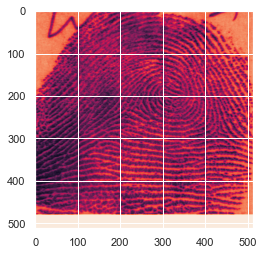

In [100]:
image_1_path = r'NIST_Database\sd04\png_txt\figs_0\f0001_01.png'
img=mpimg.imread(image_1_path)
plt.imshow(img);

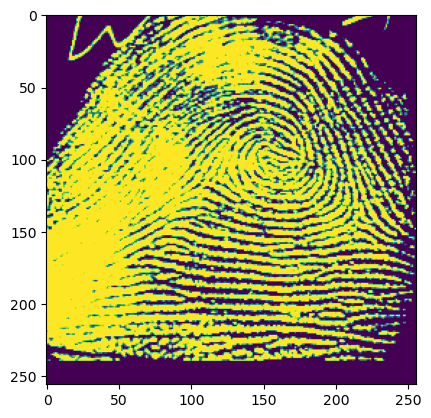

In [106]:
plt.imshow(images[0]);

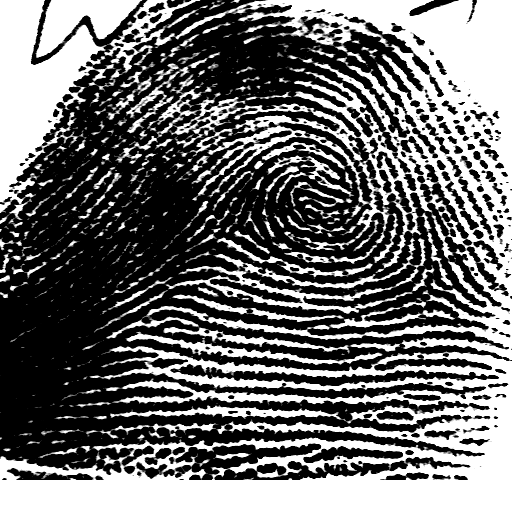

In [ ]:
enhancer = ImageEnhance.Contrast(Image.open(image_1_path))
factor = 10 #increase constrast
img = enhancer.enhance(factor)
img

#### Why this data set?

 Our goal was to apply TDA methods on new datasets, without any article or tutorial dealing with this dataset. So we searched a large number of datasets on https://www.kaggle.com/datasets and https://datasetsearch.research.google.com/ and randomly chose fingerprints (well, not quite randomly). The motivation is that fingerprints are composed of connected lines, so we assumed that we might be able to get some structures or features that would be extracted by persistence diagrams. After preprocessing the data, we searched for papers that would have already worked on fingerprints and found that SVM is generally the most used method (with different similarity distances) http://eprints.utar.edu.my/3950/1/16ACB02809_FYP.pdf , https://lup.lub.lu.se/luur/download?func=downloadFile&recordOId=8954340&fileOId=8954341 along with CNN used for gender classification https://medium.com/swlh/fingerprint-gender-classification-cnn-8b052a162a93 and other more algorithmic methods that detect loops and singularity points https://www.sciencedirect.com/science/article/abs/pii/0031320395001069 (with a classification accuracy of 85.4% for the five-class problem). But the only paper that interested us was [Graph Representation of Fingerprint Topology] (https://www.semanticscholar.org/paper/Graph-Representation-of-Fingerprint-Topology-%E2%88%97-%C3%96lz-Kropatsch/bb8ed547cc7d3c84111e63365b167672dda715da), the one that shows that a graphical representation is possible for fingerprints, which reassured us to continue.
 

![image.png](fingerprint.png)
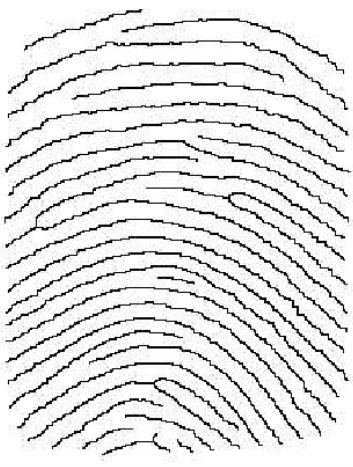

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
gender_classes_bi= lb.fit_transform(gender_classes)
lb2 = LabelBinarizer()
classes_bi=lb2.fit_transform(classes)

## Two-class classification:

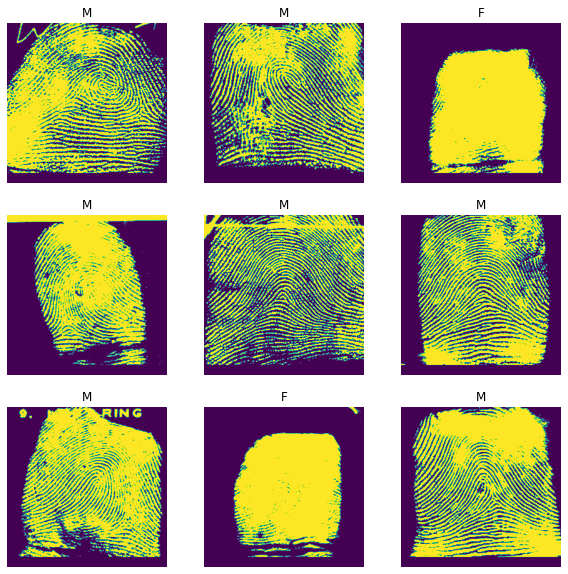

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(gender_classes[i])
    plt.axis("off")

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, gender_classes_bi, test_size=0.33, random_state=42)

In [8]:
xtrain = np.expand_dims(X_train, axis=-1)
xtest = np.expand_dims(X_test, axis=-1)

Let's start with a convolutional neural network (CNN) We tried different structures (adding different layers and different activation functions) to get a benchmark. Adding too many parameters leads to overfitting.

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop_after_epochs = 15
model = Sequential()
model.add(Conv2D(128, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_after_epochs)

In [15]:
history_test = model.fit(xtrain,y_train,batch_size=64,epochs=50,validation_data=(xtest, y_test),callbacks=[early_stopping])


Epoch 1/50
42/42 [==============================] - 274s 6s/step - loss: 0.5746 - accuracy: 0.7892 - val_loss: 0.4293 - val_accuracy: 0.8121
Epoch 2/50
42/42 [==============================] - 262s 6s/step - loss: 0.4448 - accuracy: 0.8168 - val_loss: 0.4547 - val_accuracy: 0.8250
Epoch 3/50
42/42 [==============================] - 246s 6s/step - loss: 0.4147 - accuracy: 0.8328 - val_loss: 0.3916 - val_accuracy: 0.8205
Epoch 4/50
42/42 [==============================] - 246s 6s/step - loss: 0.3727 - accuracy: 0.8522 - val_loss: 0.3832 - val_accuracy: 0.8280
Epoch 5/50
42/42 [==============================] - 232s 6s/step - loss: 0.3409 - accuracy: 0.8578 - val_loss: 0.4640 - val_accuracy: 0.8265
Epoch 6/50
42/42 [==============================] - 226s 5s/step - loss: 0.3105 - accuracy: 0.8716 - val_loss: 0.4665 - val_accuracy: 0.8318
Epoch 7/50
42/42 [==============================] - 200s 5s/step - loss: 0.2816 - accuracy: 0.8795 - val_loss: 0.3836 - val_accuracy: 0.8379
Epoch 8/50
42

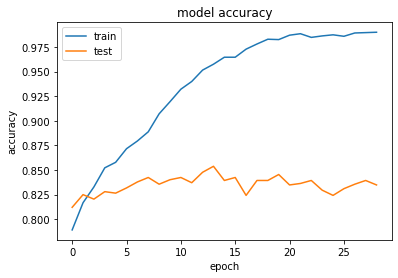

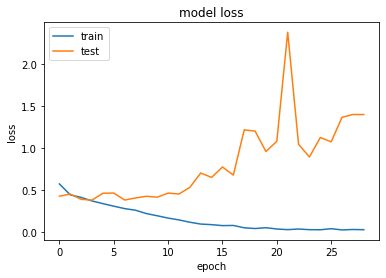

In [18]:
# summarize history for accuracy
plt.plot(history_test.history['accuracy'])
plt.plot(history_test.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_test.history['loss'])
plt.plot(history_test.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop_after_epochs = 15
model = Sequential()
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_after_epochs)

In [ ]:
history = model.fit(xtrain,y_train,batch_size=64,epochs=50,validation_data=(xtest, y_test),callbacks=[early_stopping])


Epoch 1/50
21/21 [==============================] - 51s 2s/step - loss: 0.5620 - accuracy: 0.7799 - val_loss: 0.4539 - val_accuracy: 0.8212
Epoch 2/50
21/21 [==============================] - 48s 2s/step - loss: 0.4305 - accuracy: 0.8243 - val_loss: 0.4295 - val_accuracy: 0.8182
Epoch 3/50
21/21 [==============================] - 49s 2s/step - loss: 0.4062 - accuracy: 0.8313 - val_loss: 0.4023 - val_accuracy: 0.8258
Epoch 4/50
21/21 [==============================] - 48s 2s/step - loss: 0.3799 - accuracy: 0.8478 - val_loss: 0.4053 - val_accuracy: 0.8205
Epoch 5/50
21/21 [==============================] - 49s 2s/step - loss: 0.3501 - accuracy: 0.8578 - val_loss: 0.4249 - val_accuracy: 0.8265
Epoch 6/50
21/21 [==============================] - 49s 2s/step - loss: 0.3364 - accuracy: 0.8694 - val_loss: 0.3765 - val_accuracy: 0.8386
Epoch 7/50
21/21 [==============================] - 49s 2s/step - loss: 0.2903 - accuracy: 0.8799 - val_loss: 0.3780 - val_accuracy: 0.8455
Epoch 8/50
21/21 [==

The diverging CNN performs better

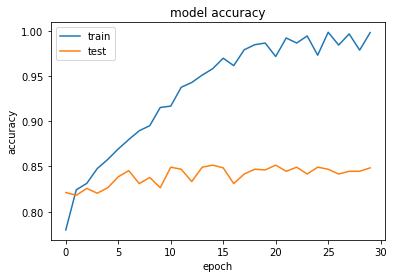

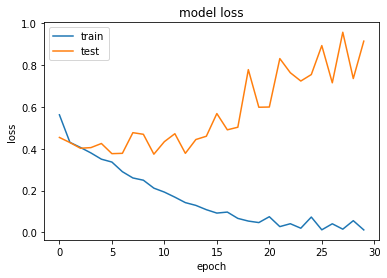

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now let's use the TDA tools. The most important tool we have is the persistence diagrams, as we saw in the first part of the project. (You can find more information about it in the notebook of part 1)
In particular, we will use persistence images which are a stable vector representation of persistent homology/persistent diagrams. 
The idea is to convert a persistent diagram into a finite dimensional vector representation which we call a persistence image. Persistence images can be used with vector-based machine learning tools.


In [79]:
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

In [80]:
rips = Rips(maxdim=1, coeff=2)
diagrams = [rips.fit_transform(img) for img in images]
diagrams_h1 = [rips.fit_transform(img)[1] for img in images]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


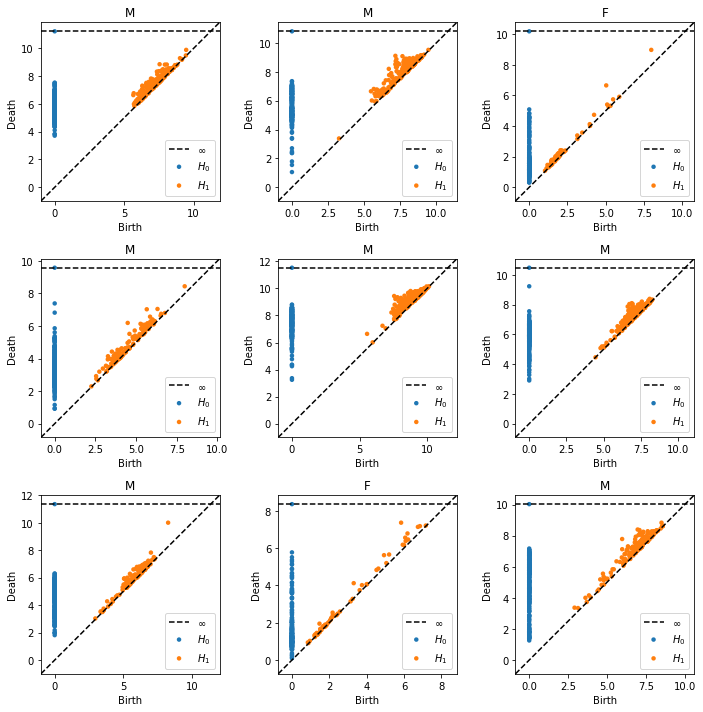

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rips.plot(diagrams[i], show=False)
    plt.tight_layout()
    plt.title(gender_classes[i])
    #plt.axis("off")

In [81]:
pimgr = PersistenceImager(pixel_size=0.25)
pimgr.fit(diagrams_h1)
imgs = pimgr.transform(diagrams_h1)

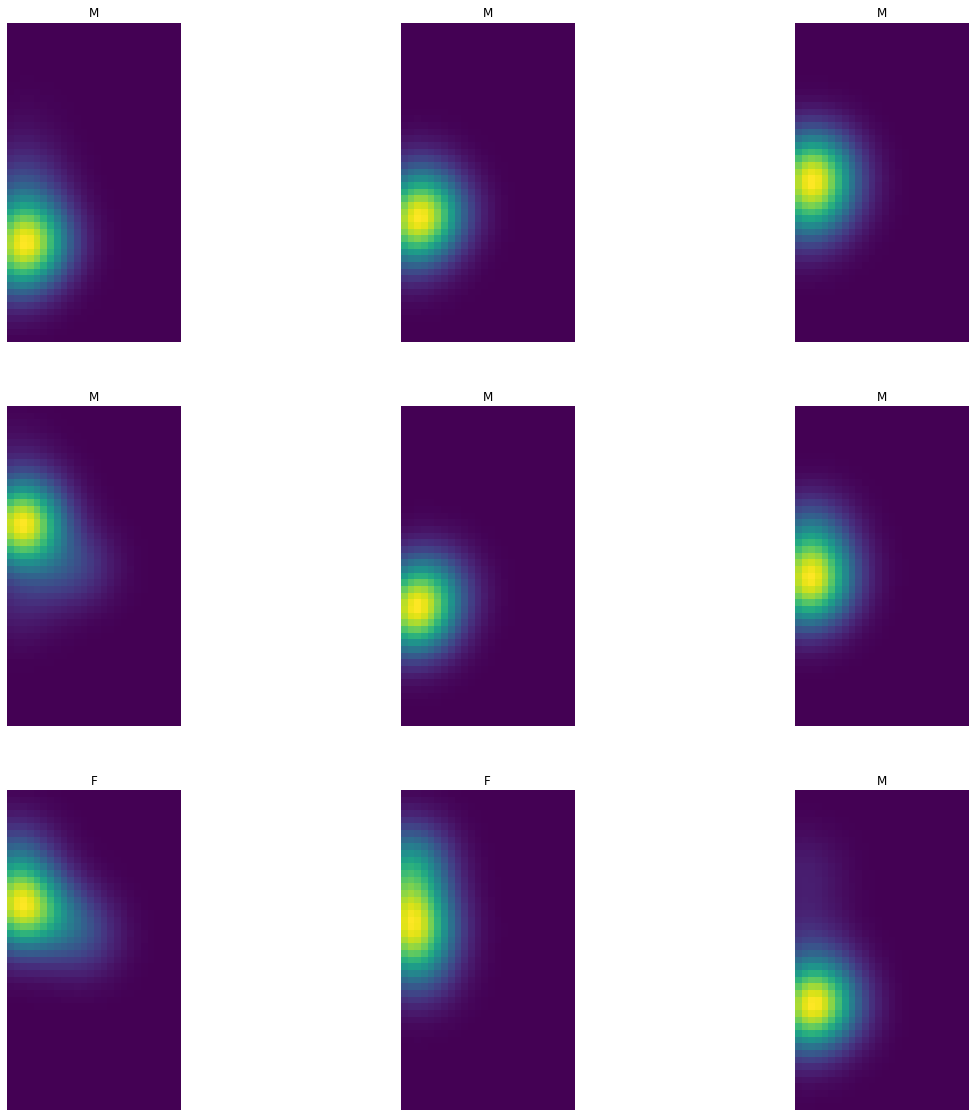

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    k=np.random.choice(range(len(imgs)))
    plt.imshow(imgs[k])
    plt.title(gender_classes[k])
    plt.axis("off")

In [82]:
imgs_array = np.array([img.flatten() for img in imgs])

In [83]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array,gender_classes_bi , test_size=0.40, random_state=42)

In [84]:
X_train[0].shape

(1248,)

 We use vectors of size 1248, we can use other sizes by changing the pixel_size (to 1 for example). We will also try vectors of size 84. And for classification, we will only use logistic regression.

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

The test accuracy is :

In [ ]:
lr.score(X_test, y_test)

0.804375

While for the neural network its  : 

In [ ]:
np.mean(history.history['val_accuracy'])

0.8399747530619304

In [ ]:
pimgr2 = PersistenceImager(pixel_size=1)
pimgr2.fit(diagrams_h1)
imgs2 = pimgr2.transform(diagrams_h1)

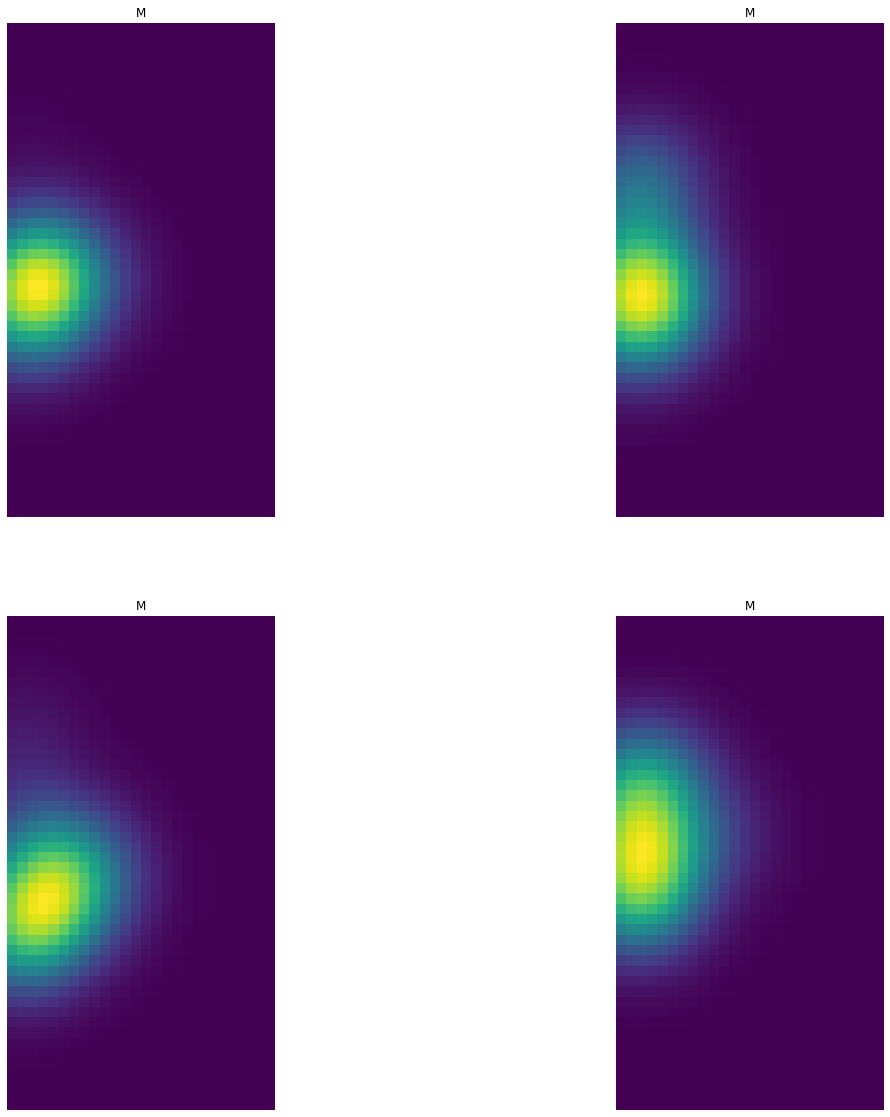

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    k=np.random.choice(range(len(imgs2)))
    plt.imshow(imgs[k])
    plt.title(gender_classes[k])
    plt.axis("off")

In [ ]:
imgs2_array = np.array([img.flatten() for img in imgs2])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(imgs2_array,gender_classes_bi , test_size=0.40, random_state=42)

In [ ]:
X_train[0].shape

(84,)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
lr.score(X_test, y_test)

0.805

So we get an accuracy of 80.5%, while the neural network it was 83.99%. Although the neural network performs better, it should be noted that we only use vectors of size 84 + simple logistic regression, whereas the neural network, well it's a neural network, uses 256*256 images, so the persistence images have a huge time and memory advantage.


But, as we will see next. The dataset is unbalanced with respect to gender classification (we won't have this problem with the five-class finger classification). So we will balance the data using the SMOTE synthetic minority oversampling technique. And since we don't want to give the model exactly the same data, we will modify each image by rotating it with a random angle of a normal N(0,3) distribution.

In [ ]:
list(gender_classes).count('M')

3250

In [ ]:
list(gender_classes).count('F')

750

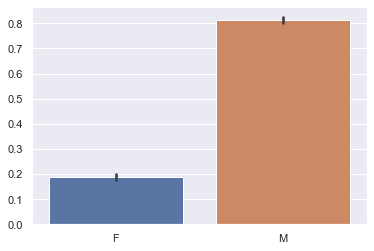

In [ ]:
sns.set_theme(style="darkgrid")
df_data=pd.DataFrame({'F':np.array(gender_classes=='F').astype('int32'), 'M':np.array(gender_classes=='M').astype('int32')})


ax = sns.barplot(data=df_data)

In [ ]:
list(gender_classes).count('F')/list(gender_classes).count('M')*100

23.076923076923077

In [ ]:
print("A classifier that always gives 'M' will ahve an accuracy of {} %".format(100-list(gender_classes).count('F')/list(gender_classes).count('M')*100))

A classifier that always gives 'M' will ahve an accuracy of 76.92307692307692 %


In [6]:
shape_or = images[0].shape
images_flat = np.array([img.flatten() for img in images ])
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
images_over, gender_classes_bi_over = oversample.fit_resample(images_flat, gender_classes_bi)
images_over = np.array([img.reshape(shape_or) for img in images_over ])

In [7]:
from PIL import Image

for i in range(len(images_over)):
    img=images_over[i]
    PIL_image = Image.fromarray(img.astype('uint8'))
    angle = np.random.normal(0,3)
    PIL_image = PIL_image.rotate(angle)
    images_over[i]=np.array(PIL_image)

In [24]:
rips = ripser.Rips(maxdim=1, coeff=2)
diagrams_ = [rips.fit_transform(img) for img in images_over]
diagrams_h1_ = [diag[1] for diag in diagrams_]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [25]:
pimgr_ = PersistenceImager(pixel_size=0.25)
pimgr_.fit(diagrams_h1_)
imgs_ = pimgr_.transform(diagrams_h1_)
imgs_array= np.array([img.flatten() for img in imgs_ ])

With logistic regression

In [26]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array,gender_classes_bi_over , test_size=0.40, random_state=42)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.806923076923077

The accuracy didnt really change that much. Now let's see with the neural network.

In [ ]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(images_over, gender_classes_bi_over, test_size=0.3, random_state=69)
xtrain2 = np.expand_dims(X_train2, axis=-1)
xtest2 = np.expand_dims(X_test2, axis=-1)
X_train, X_test, y_train, y_test = train_test_split(imgs_array, gender_classes_bi_over, test_size=0.3, random_state=69)
xtrain = np.expand_dims(X_train, axis=-1)
xtest = np.expand_dims(X_test, axis=-1)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
early_stop_after_epochs = 10
model = Sequential()
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(128, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_after_epochs)

In [ ]:
history = model.fit(xtrain2,y_train,batch_size=64,epochs=50,validation_data=(xtest2, y_test),callbacks=[early_stopping])


Epoch 1/50
72/72 [==============================] - 117s 2s/step - loss: 0.6335 - accuracy: 0.7536 - val_loss: 0.4079 - val_accuracy: 0.8215
Epoch 2/50
72/72 [==============================] - 115s 2s/step - loss: 0.4162 - accuracy: 0.8281 - val_loss: 0.8992 - val_accuracy: 0.6882
Epoch 3/50
72/72 [==============================] - 115s 2s/step - loss: 0.3383 - accuracy: 0.8626 - val_loss: 0.4435 - val_accuracy: 0.8246
Epoch 4/50
72/72 [==============================] - 115s 2s/step - loss: 0.2518 - accuracy: 0.8996 - val_loss: 0.4181 - val_accuracy: 0.8246
Epoch 5/50
72/72 [==============================] - 116s 2s/step - loss: 0.1777 - accuracy: 0.9327 - val_loss: 0.3871 - val_accuracy: 0.8713
Epoch 6/50
72/72 [==============================] - 119s 2s/step - loss: 0.1085 - accuracy: 0.9596 - val_loss: 0.3847 - val_accuracy: 0.8836
Epoch 7/50
72/72 [==============================] - 119s 2s/step - loss: 0.0668 - accuracy: 0.9756 - val_loss: 0.4616 - val_accuracy: 0.8718
Epoch 8/50
72

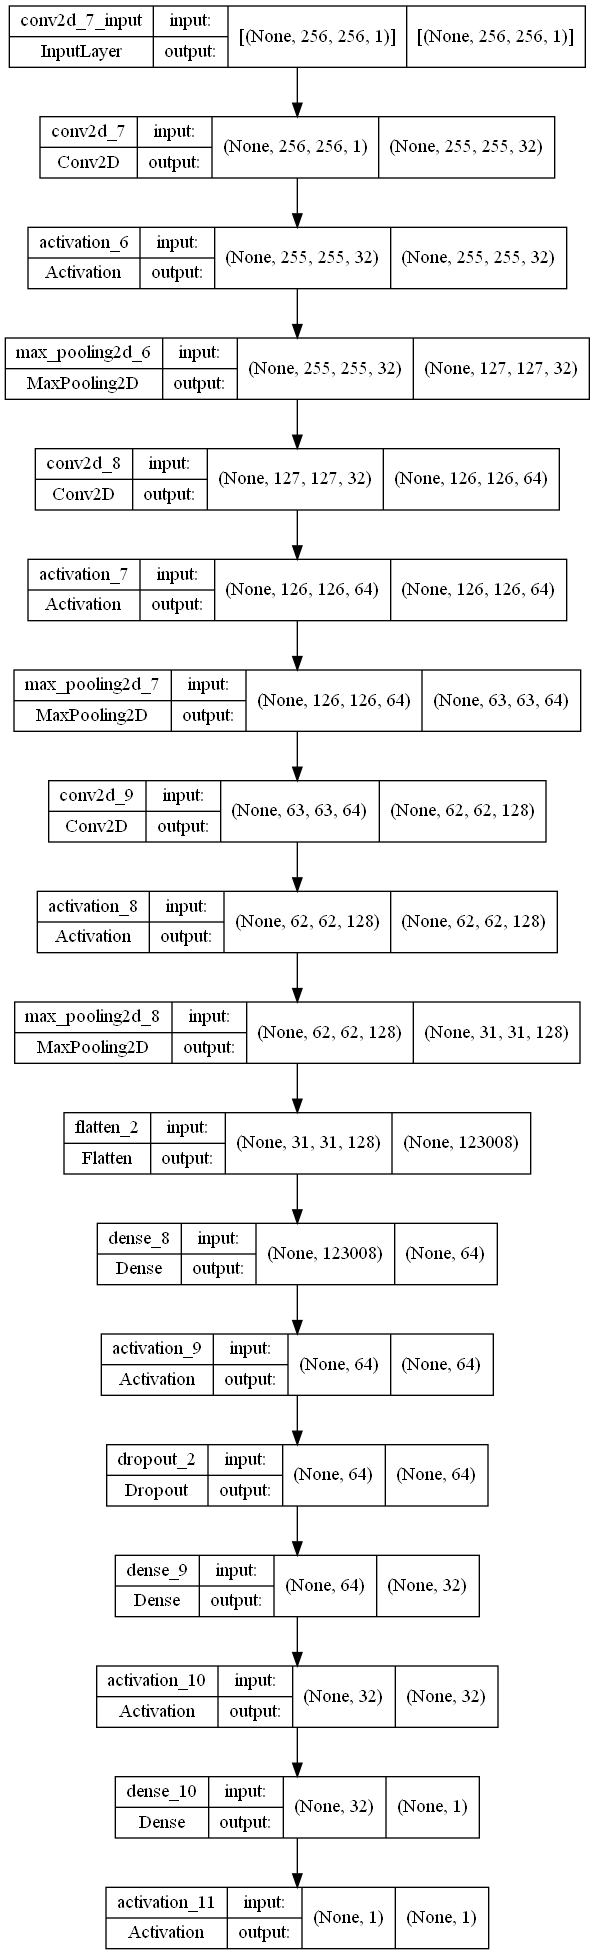

In [ ]:
plot_model(model,show_shapes=True, show_layer_names=True)

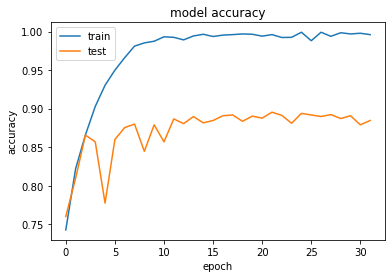

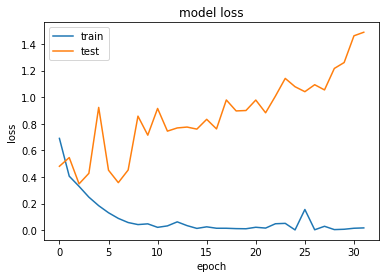

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

An other possible use of persistence diagrams or persistence images is using them for feature augmentation. We create a neural network that takes as input both the image and its corresponding persistence image.

In [ ]:
from tensorflow.keras.layers import concatenate, Input ,Flatten,Dense,Dropout
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D

In [ ]:
input_images = Input(shape=(X_train2[0].shape[0], X_train2[0].shape[1],1,))
x = Conv2D(kernel_size=(4,4), filters=32, activation='selu')(input_images)
x = MaxPool2D(5,5)(x)
x = Conv2D(filters=64,kernel_size = (3,3),activation='selu')(x)
x = MaxPool2D(2,2)(x)
x = Conv2D(filters=128,kernel_size = (3,3),activation='relu')(x)
x = MaxPool2D(2,2)(x)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = Model(inputs=input_images, outputs=x)

#second model #two options (images or not)
input_features = Input(shape=(X_train[0].shape[0],))
y = Dense(X_train[0].shape[0],activation='relu')(input_features)
y = Dense(64,activation='relu')(y)
y = Model(inputs=input_features, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs




z = Dense(32,activation=tf.keras.layers.LeakyReLU(alpha=0.3))(combined)
z = Dropout(0.2)(z)
z= Dense(1,activation = 'sigmoid')(z)
model_2 = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
model_2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

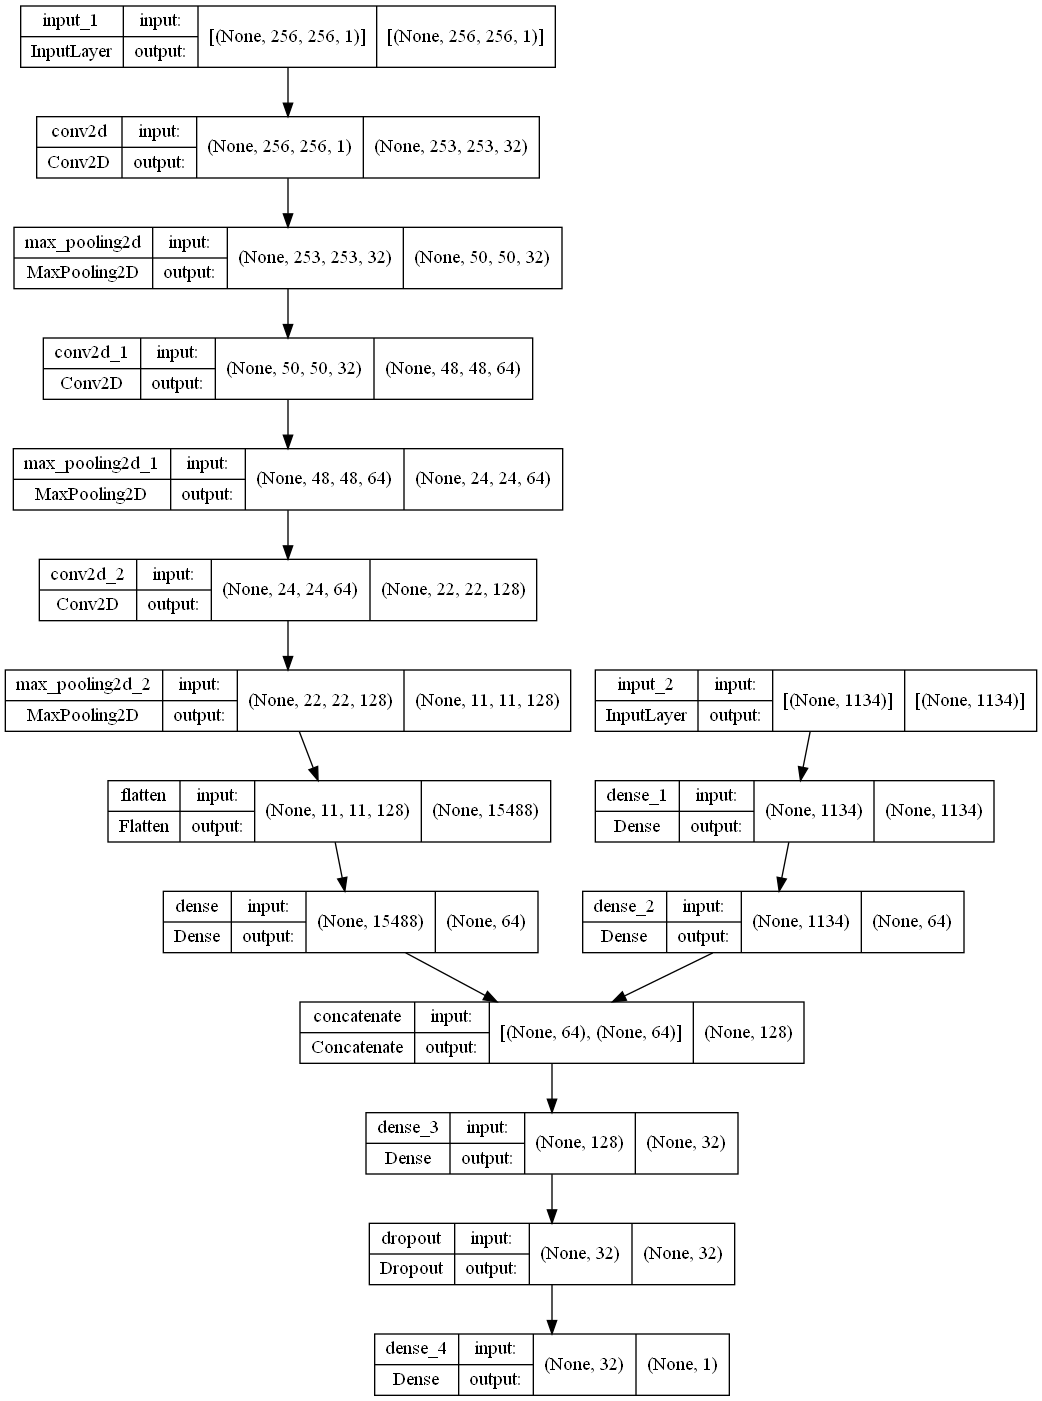

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history_2=model_2.fit( x=[xtrain2, xtrain], y=y_train, validation_data=([xtest2, xtest], y_test), epochs=32, batch_size=32)


Epoch 1/32
143/143 [==============================] - 74s 498ms/step - loss: 0.5062 - accuracy: 0.7703 - val_loss: 0.4903 - val_accuracy: 0.7723
Epoch 2/32
143/143 [==============================] - 74s 519ms/step - loss: 0.3994 - accuracy: 0.8341 - val_loss: 0.3405 - val_accuracy: 0.8564
Epoch 3/32
143/143 [==============================] - 72s 506ms/step - loss: 0.3459 - accuracy: 0.8598 - val_loss: 0.4738 - val_accuracy: 0.7892
Epoch 4/32
143/143 [==============================] - 74s 516ms/step - loss: 0.3054 - accuracy: 0.8778 - val_loss: 0.3263 - val_accuracy: 0.8677
Epoch 5/32
143/143 [==============================] - 73s 510ms/step - loss: 0.2571 - accuracy: 0.8996 - val_loss: 0.2935 - val_accuracy: 0.8923
Epoch 6/32
143/143 [==============================] - 74s 518ms/step - loss: 0.2144 - accuracy: 0.9130 - val_loss: 0.2895 - val_accuracy: 0.9021
Epoch 7/32
143/143 [==============================] - 74s 518ms/step - loss: 0.1780 - accuracy: 0.9305 - val_loss: 0.3071 - val_ac

<AxesSubplot:>

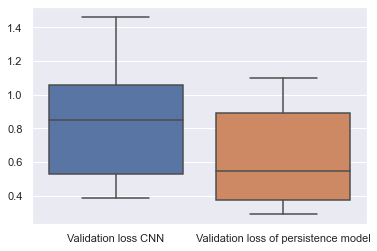

In [56]:
histories_loss = [history.history['val_loss'],history_2.history['val_loss']]

sns.boxplot(data= pd.DataFrame (list(map(list, zip(*histories_loss))), columns = ['Validation loss CNN','Validation loss of persistence model']),showfliers=False)

<AxesSubplot:>

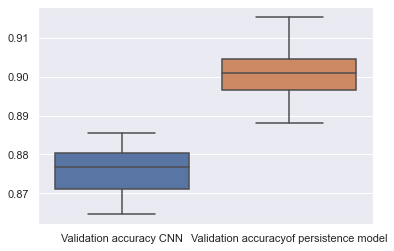

In [57]:
histories_accuracy= [history.history['val_accuracy'][5:],history_2.history['val_accuracy'][5:]]
sns.boxplot(data= pd.DataFrame (list(map(list, zip(*histories_accuracy))), columns = ['Validation accuracy CNN','Validation accuracyof persistence model']),showfliers=False)

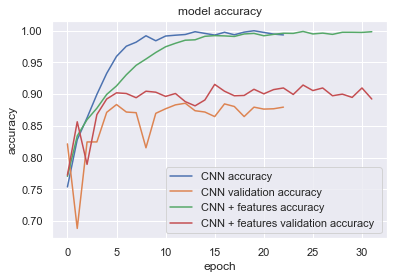

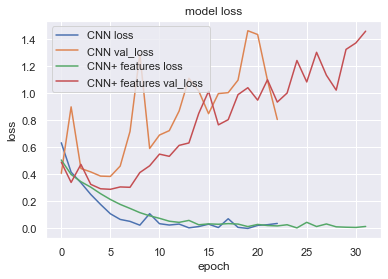

In [58]:
# summarize history for accuracy
plt.plot(history.history['accuracy'],label = 'CNN accuracy ')
plt.plot(history.history['val_accuracy'],label = 'CNN validation accuracy ')
plt.plot(history_2.history['accuracy'],label = 'CNN + features accuracy ')
plt.plot(history_2.history['val_accuracy'],label = 'CNN + features validation accuracy ')
                    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],label = 'CNN loss ')
plt.plot(history.history['val_loss'],label = 'CNN val_loss ')
plt.plot(history_2.history['loss'],label = 'CNN+ features loss ')
plt.plot(history_2.history['val_loss'],label = 'CNN+ features val_loss ')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [77]:
#X_train, X_test, y_train, y_test = train_test_split([img.flatten() for img in imgstrain_array],y_train, test_size=0.3, random_state=42)
from sklearn.metrics import accuracy_score

import lightgbm as lgb
lgbc = lgb.LGBMClassifier()
lgbc.fit(X_train, y_train)
y_pred=clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.38%


In [79]:
from xgboost import XGBClassifier

XGBC = XGBClassifier() 
XGBC.fit(X_train, y_train)
y_pred = XGBC.predict(X_test) 
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))


[06:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 80.26%


In [80]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8056410256410257

## Classification into five classes

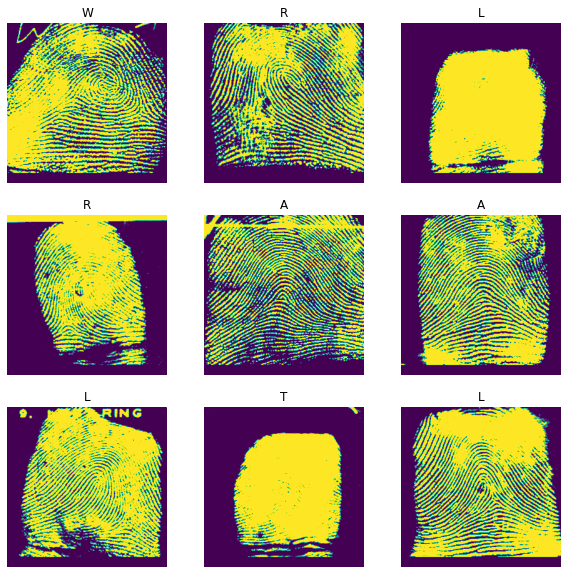

In [79]:

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[i])
    plt.axis("off")

In [80]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(images, classes_bi, test_size=0.33, random_state=42)

In [81]:
xtrain2 = np.expand_dims(X_train2, axis=-1)
xtest2 = np.expand_dims(X_test2, axis=-1)


In [60]:
from tensorflow.keras.layers import concatenate, Input ,Flatten,Dense,Dropout
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D

In [82]:
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D
# Creating a Sequential model
model2= Sequential()
model2.add(Conv2D(kernel_size=(10,10), filters=32, activation='selu'))#, input_shape=(100,100,1,)))
model2.add(MaxPool2D(5,5))
model2.add(Conv2D(filters=30,kernel_size = (3,3),activation='selu')) #activation='tanh'
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(filters=30,kernel_size = (3,3),activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(filters=30,kernel_size = (3,3),activation='tanh'))

model2.add(Flatten())

model2.add(Dense(30,activation='selu'))
model2.add(Dropout(0.2))
model2.add(Dense(15,activation='selu'))
model2.add(Dense(5,activation = 'softmax')) #sigmoid
    
model2.compile(loss='categorical_crossentropy', metrics=['acc'],optimizer='adam')

In [83]:
history2=model2.fit(xtrain2,y_train2,batch_size=32,epochs=50,validation_data=(xtest2, y_test2))
#val_acc: 0.6129

Epoch 1/50
84/84 [==============================] - 93s 1s/step - loss: 1.4649 - acc: 0.3377 - val_loss: 1.2022 - val_acc: 0.4561
Epoch 2/50
84/84 [==============================] - 92s 1s/step - loss: 1.0384 - acc: 0.5634 - val_loss: 1.0206 - val_acc: 0.5576
Epoch 3/50
84/84 [==============================] - 91s 1s/step - loss: 0.9146 - acc: 0.6250 - val_loss: 0.8856 - val_acc: 0.6182
Epoch 4/50
84/84 [==============================] - 91s 1s/step - loss: 0.8840 - acc: 0.6433 - val_loss: 0.8518 - val_acc: 0.6523
Epoch 5/50
84/84 [==============================] - 91s 1s/step - loss: 0.8077 - acc: 0.6765 - val_loss: 0.7641 - val_acc: 0.6735
Epoch 6/50
84/84 [==============================] - 91s 1s/step - loss: 0.7497 - acc: 0.7067 - val_loss: 0.8132 - val_acc: 0.6735
Epoch 7/50
84/84 [==============================] - 91s 1s/step - loss: 0.7151 - acc: 0.7146 - val_loss: 0.7441 - val_acc: 0.6894
Epoch 8/50
84/84 [==============================] - 91s 1s/step - loss: 0.6275 - acc: 0.75

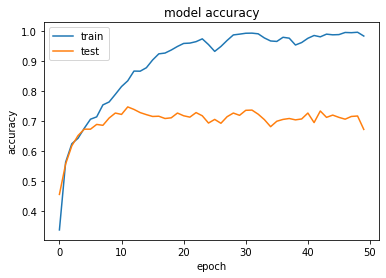

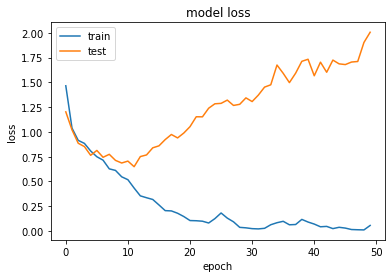

In [85]:
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

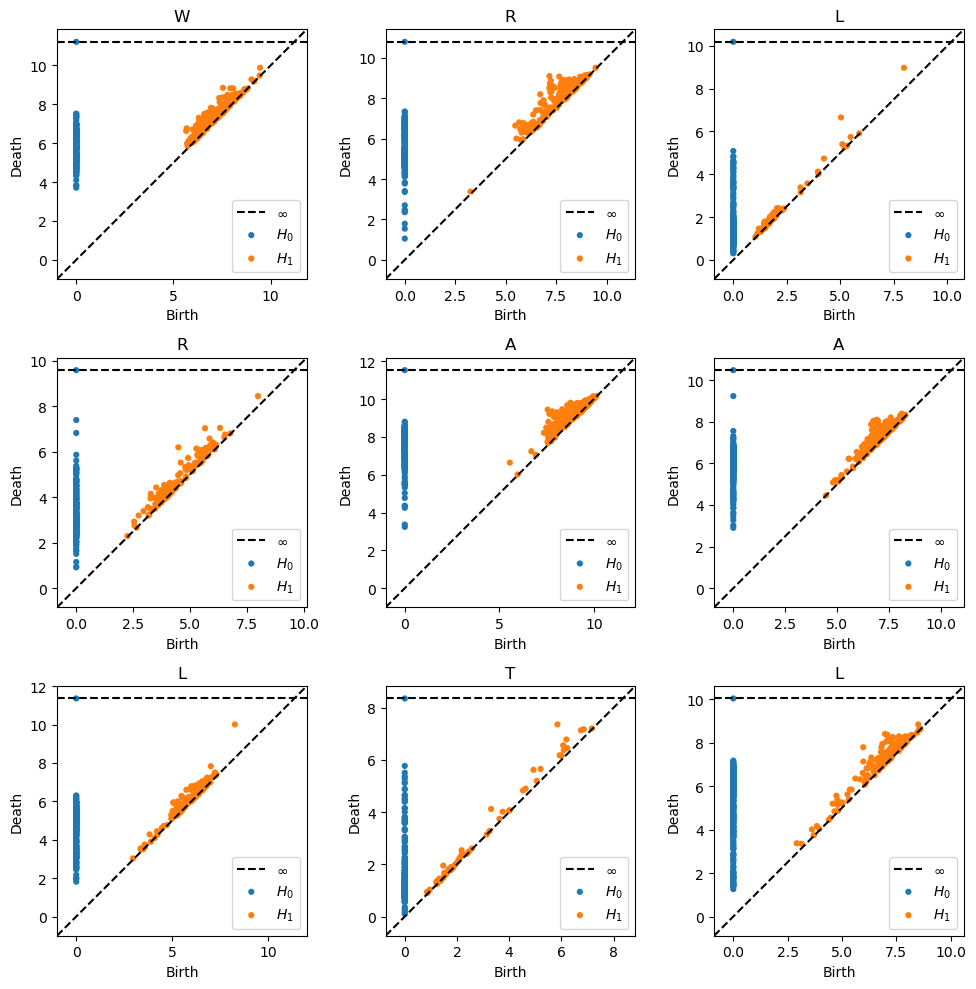

In [113]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rips.plot(diagrams[i], show=False)
    plt.tight_layout()
    plt.title(classes[i])
    #plt.axis("off")

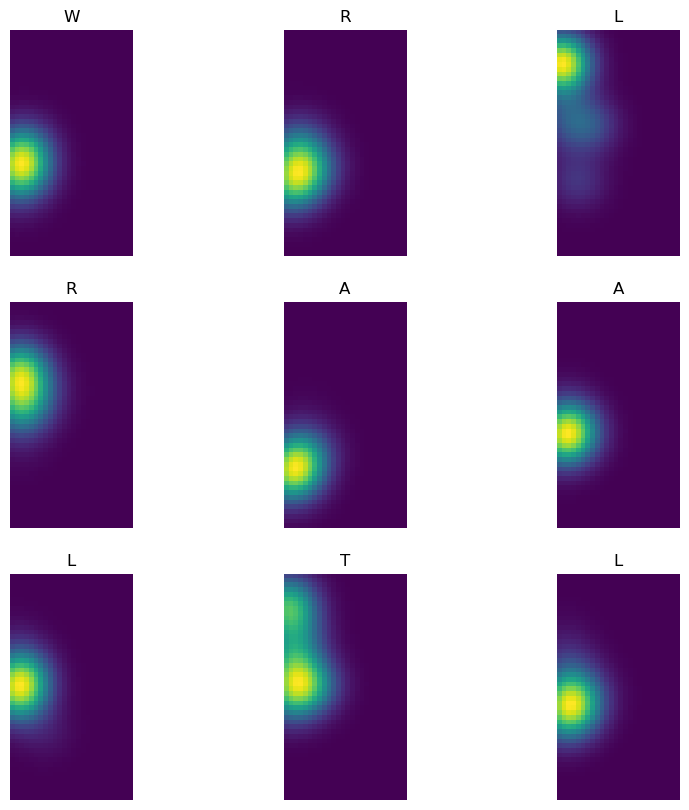

In [114]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i])
    plt.title(classes[i])
    plt.axis("off")

In [66]:
rips = ripser.Rips(maxdim=1, coeff=2)
diagrams_5 = [rips.fit_transform(img) for img in images]
diagrams_h1_5 = [diag[1] for diag in diagrams_5]
pimgr_5 = PersistenceImager(pixel_size=0.25)
pimgr_5.fit(diagrams_h1_5)
imgs_5 = pimgr_5.transform(diagrams_h1_5)
imgs_array_5c= np.array([img.flatten() for img in imgs_5 ])

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [68]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(images, classes_bi, test_size=0.3, random_state=69)
xtrain2 = np.expand_dims(X_train2, axis=-1)
xtest2 = np.expand_dims(X_test2, axis=-1)
X_train, X_test, y_train, y_test = train_test_split(imgs_array_5c, classes_bi, test_size=0.3, random_state=69)
xtrain = np.expand_dims(X_train, axis=-1)
xtest = np.expand_dims(X_test, axis=-1)

In [69]:
from tensorflow.keras.layers import concatenate, Input ,Flatten,Dense,Dropout
from tensorflow.keras.models import Model

In [70]:
X_train[0].shape

(1248,)

In [71]:
X_train2[0].shape

(256, 256)

In [72]:
input_images = Input(shape=(X_train2[0].shape[0], X_train2[0].shape[1],1,))
x = Conv2D(kernel_size=(10,10), filters=32, activation='selu')(input_images)
x = MaxPool2D(5,5)(x)
x = Conv2D(filters=30,kernel_size = (3,3),activation='selu')(x)
x = MaxPool2D(2,2)(x)
x = Conv2D(filters=30,kernel_size = (3,3),activation='relu')(x)
x = MaxPool2D(2,2)(x)
x = Conv2D(filters=30,kernel_size = (3,3),activation='tanh')(x)
x = Flatten()(x)
x = Model(inputs=input_images, outputs=x)

#second model #two options (images or not)
input_features = Input(shape=(X_train[0].shape[0],))
y = Dense(X_train[0].shape[0],activation='relu')(input_features)
y = Dense(10,activation='relu')(y)
y = Model(inputs=input_features, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(20,activation='selu')(combined)
z = Dropout(0.2)(z)
z = Dense(10,activation=tf.keras.layers.LeakyReLU(alpha=0.3))(z)
z= Dense(5,activation = 'softmax')(z)
model3 = Model(inputs=[x.input, y.input], outputs=z)

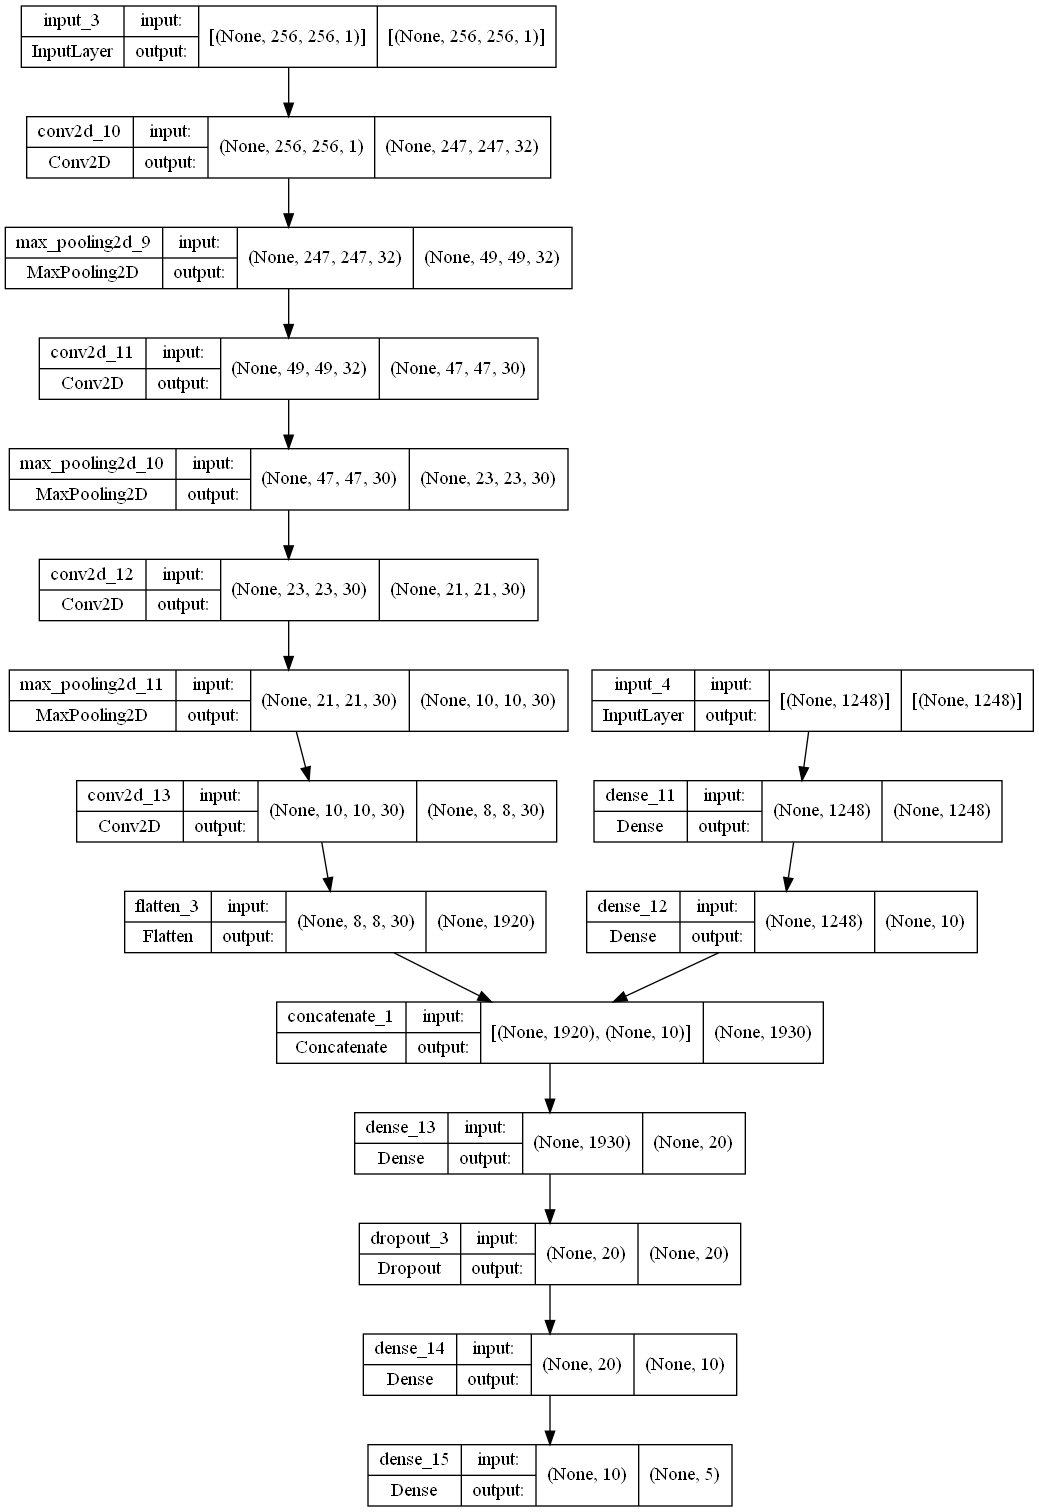

In [73]:
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [74]:
model3.compile(loss='categorical_crossentropy', metrics=['acc'],optimizer='adam')

In [75]:
history3=model3.fit( x=[xtrain2, xtrain], y=y_train, validation_data=([xtest2, xtest], y_test), epochs=50, batch_size=32)


Epoch 1/50
88/88 [==============================] - 91s 1s/step - loss: 1.6143 - acc: 0.2304 - val_loss: 1.5822 - val_acc: 0.2925
Epoch 2/50
88/88 [==============================] - 90s 1s/step - loss: 1.5746 - acc: 0.2643 - val_loss: 1.5227 - val_acc: 0.3092
Epoch 3/50
88/88 [==============================] - 89s 1s/step - loss: 1.3288 - acc: 0.4371 - val_loss: 1.1082 - val_acc: 0.5383
Epoch 4/50
88/88 [==============================] - 90s 1s/step - loss: 0.9825 - acc: 0.5936 - val_loss: 0.9007 - val_acc: 0.6300
Epoch 5/50
88/88 [==============================] - 90s 1s/step - loss: 0.8580 - acc: 0.6536 - val_loss: 0.8362 - val_acc: 0.6567
Epoch 6/50
88/88 [==============================] - 90s 1s/step - loss: 0.8030 - acc: 0.6646 - val_loss: 0.8199 - val_acc: 0.6750
Epoch 7/50
88/88 [==============================] - 90s 1s/step - loss: 0.7052 - acc: 0.7139 - val_loss: 0.7684 - val_acc: 0.7083
Epoch 8/50
88/88 [==============================] - 90s 1s/step - loss: 0.6554 - acc: 0.73

<AxesSubplot:>

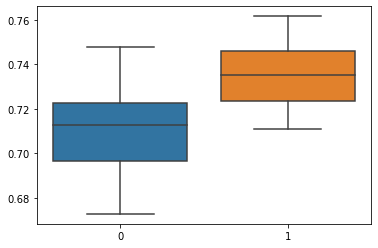

In [145]:
sns.boxplot(data=[history2.history['val_acc'],history3.history['val_acc']],showfliers=False)

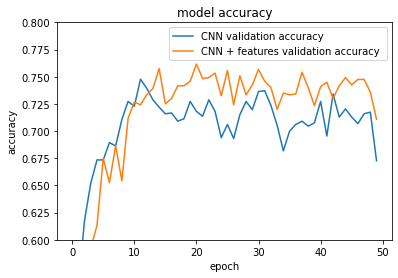

In [149]:
plt.plot(history2.history['val_acc'],label = 'CNN validation accuracy ')
plt.plot(history3.history['val_acc'],label = 'CNN + features validation accuracy ')
plt.ylim(0.6,0.8)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

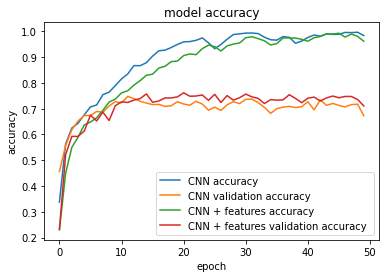

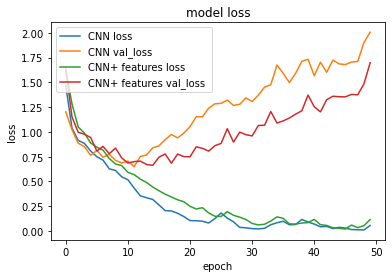

In [147]:
# summarize history for accuracy
plt.plot(history2.history['acc'],label = 'CNN accuracy ')
plt.plot(history2.history['val_acc'],label = 'CNN validation accuracy ')
plt.plot(history3.history['acc'],label = 'CNN + features accuracy ')
plt.plot(history3.history['val_acc'],label = 'CNN + features validation accuracy ')
                    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'],label = 'CNN loss ')
plt.plot(history2.history['val_loss'],label = 'CNN val_loss ')
plt.plot(history3.history['loss'],label = 'CNN+ features loss ')
plt.plot(history3.history['val_loss'],label = 'CNN+ features val_loss ')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [157]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(images, classes_bi, test_size=0.3, random_state=69)

In [158]:
xtrain2 = np.expand_dims(X_train2, axis=-1)
xtest2 = np.expand_dims(X_test2, axis=-1)

In [85]:
#
X_train, X_test, y_train, y_test = train_test_split(imgs, classes_bi, test_size=0.3, random_state=69)

In [86]:
xtrain = np.expand_dims(X_train, axis=-1)
xtest = np.expand_dims(X_test, axis=-1)

In [87]:
from tensorflow.keras.layers import concatenate, Input ,Flatten,Dense,Dropout
from tensorflow.keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D


In [88]:
X_train2[0].shape

(256, 256)

In [89]:
X_train[0].shape

(48, 26)

In [90]:
input_images = Input(shape=(X_train2[0].shape[0], X_train2[0].shape[1],1,))
x = Conv2D(kernel_size=(10,10), filters=32, activation='selu')(input_images)
x = MaxPool2D(5,5)(x)
x = Conv2D(filters=30,kernel_size = (3,3),activation='selu')(x)
x = MaxPool2D(2,2)(x)
x = Conv2D(filters=30,kernel_size = (3,3),activation='relu')(x)
x = MaxPool2D(2,2)(x)
x = Conv2D(filters=30,kernel_size = (3,3),activation='tanh')(x)
x = Flatten()(x)
x = Dense(15,activation='relu')(x)
x = Model(inputs=input_images, outputs=x)

#second model #two options (images or not)
input_features = Input(shape=(X_train[0].shape[0], X_train[0].shape[1],1,))
y = Conv2D(kernel_size=(5,5), filters=16, activation='selu')(input_features)
y = MaxPool2D(2,2)(y)
y = Conv2D(filters=10,kernel_size = (2,2),activation='selu')(y)
y = Flatten()(y)
y = Dense(15,activation='relu')(y)
y = Model(inputs=input_features, outputs=y)






# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(30,activation='selu')(combined)
z = Dropout(0.2)(z)
z = Dense(15,activation=tf.keras.layers.LeakyReLU(alpha=0.3))(z)
z= Dense(5,activation = 'softmax')(z)
# our model will accept the inputs of the two branches and
# then output a single value
model4 = Model(inputs=[x.input, y.input], outputs=z)

In [165]:
print(model4.summary())

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 247, 247, 32  3232        ['input_23[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_43 (MaxPooling2D  (None, 49, 49, 32)  0           ['conv2d_60[0][0]']              
 )                                                                                         

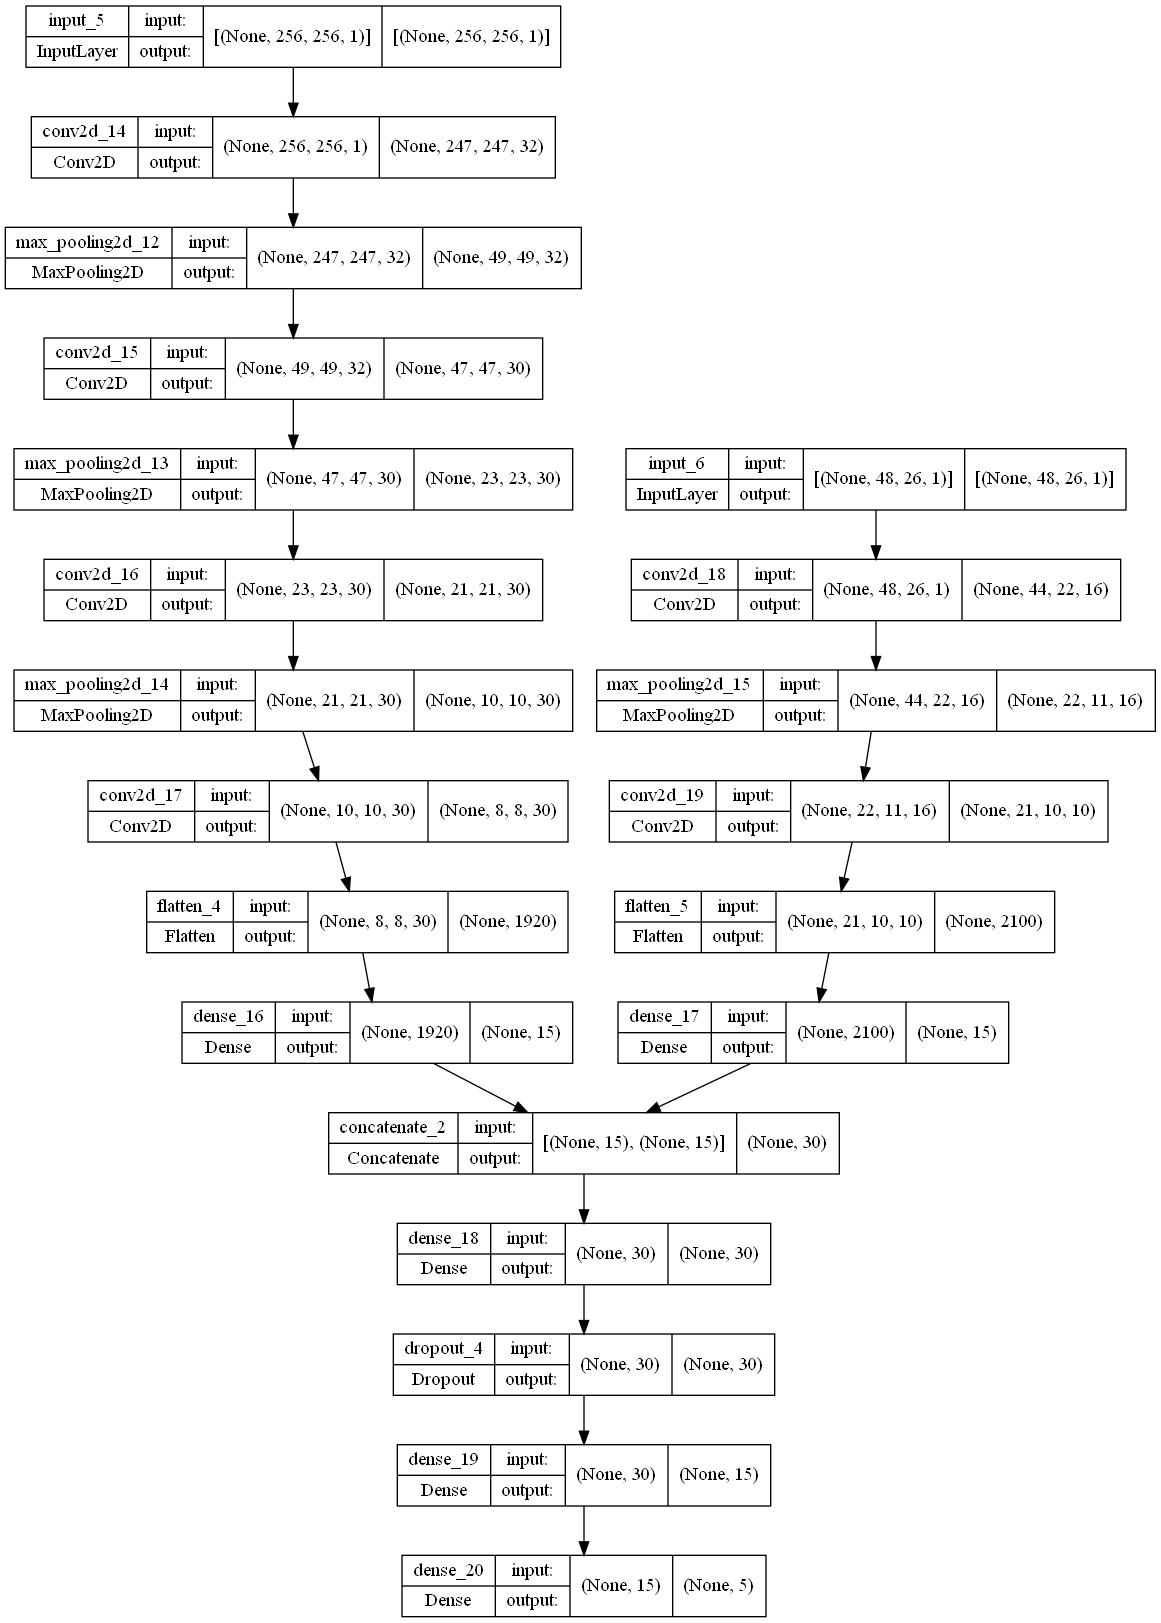

In [91]:
from keras.utils.vis_utils import plot_model
plot_model(model4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [167]:
model4.compile(loss='categorical_crossentropy', metrics=['acc'],optimizer='adam')

In [168]:
history4=model4.fit( x=[xtrain2, xtrain], y=y_train, validation_data=([xtest2, xtest], y_test), epochs=50, batch_size=32)



Epoch 1/50
88/88 [==============================] - 102s 1s/step - loss: 1.5702 - acc: 0.2657 - val_loss: 1.3820 - val_acc: 0.3700
Epoch 2/50
88/88 [==============================] - 101s 1s/step - loss: 1.2006 - acc: 0.4861 - val_loss: 1.1195 - val_acc: 0.5242
Epoch 3/50
88/88 [==============================] - 101s 1s/step - loss: 1.0401 - acc: 0.5364 - val_loss: 1.0176 - val_acc: 0.5492
Epoch 4/50
88/88 [==============================] - 101s 1s/step - loss: 0.9547 - acc: 0.5850 - val_loss: 1.1038 - val_acc: 0.5608
Epoch 5/50
88/88 [==============================] - 102s 1s/step - loss: 0.9090 - acc: 0.6150 - val_loss: 0.9506 - val_acc: 0.6083
Epoch 6/50
88/88 [==============================] - 100s 1s/step - loss: 0.8085 - acc: 0.6554 - val_loss: 0.8202 - val_acc: 0.6592
Epoch 7/50
88/88 [==============================] - 100s 1s/step - loss: 0.7317 - acc: 0.6807 - val_loss: 0.8337 - val_acc: 0.6483
Epoch 8/50
88/88 [==============================] - 101s 1s/step - loss: 0.7041 - a

<AxesSubplot:>

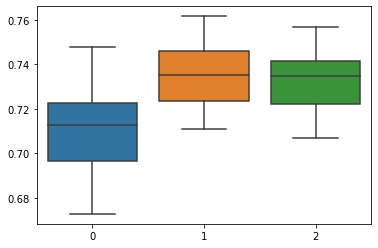

In [170]:
sns.boxplot(data=[history2.history['val_acc'],history3.history['val_acc'],history4.history['val_acc']],showfliers=False)

<AxesSubplot:>

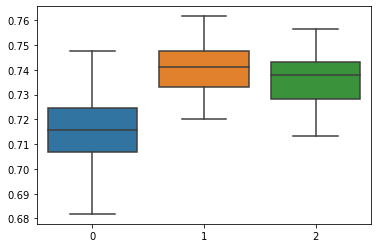

In [177]:
sns.boxplot(data=[history2.history['val_acc'][10:],history3.history['val_acc'][10:],history4.history['val_acc'][10:]],showfliers=False)

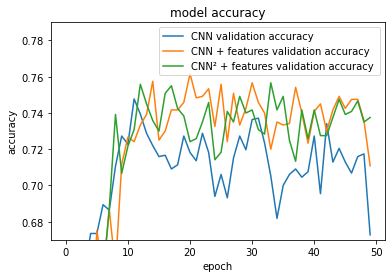

In [175]:
plt.plot(history2.history['val_acc'],label = 'CNN validation accuracy ')
plt.plot(history3.history['val_acc'],label = 'CNN + features validation accuracy ')
plt.plot(history4.history['val_acc'],label = 'CNN² + features validation accuracy ')
plt.ylim(0.67,0.79)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

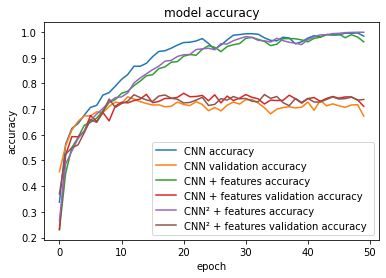

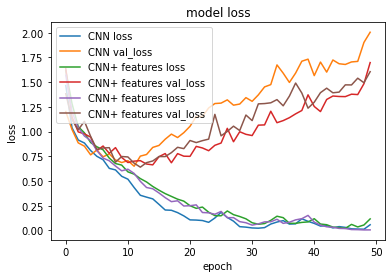

In [173]:
# summarize history for accuracy
plt.plot(history2.history['acc'],label = 'CNN accuracy ')
plt.plot(history2.history['val_acc'],label = 'CNN validation accuracy ')
plt.plot(history3.history['acc'],label = 'CNN + features accuracy ')
plt.plot(history3.history['val_acc'],label = 'CNN + features validation accuracy ')
plt.plot(history4.history['acc'],label = 'CNN² + features accuracy ')
plt.plot(history4.history['val_acc'],label = 'CNN² + features validation accuracy ')
                    
                    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'],label = 'CNN loss ')
plt.plot(history2.history['val_loss'],label = 'CNN val_loss ')
plt.plot(history3.history['loss'],label = 'CNN+ features loss ')
plt.plot(history3.history['val_loss'],label = 'CNN+ features val_loss ')
plt.plot(history4.history['loss'],label = 'CNN+ features loss ')
plt.plot(history4.history['val_loss'],label = 'CNN+ features val_loss ')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

#### Classification directe des images de persistance

In [10]:
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

In [30]:
rips = Rips(maxdim=1, coeff=2)
diagrams = [rips.fit_transform(img) for img in images]
diagrams_h1 = [rips.fit_transform(img)[1] for img in images]

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


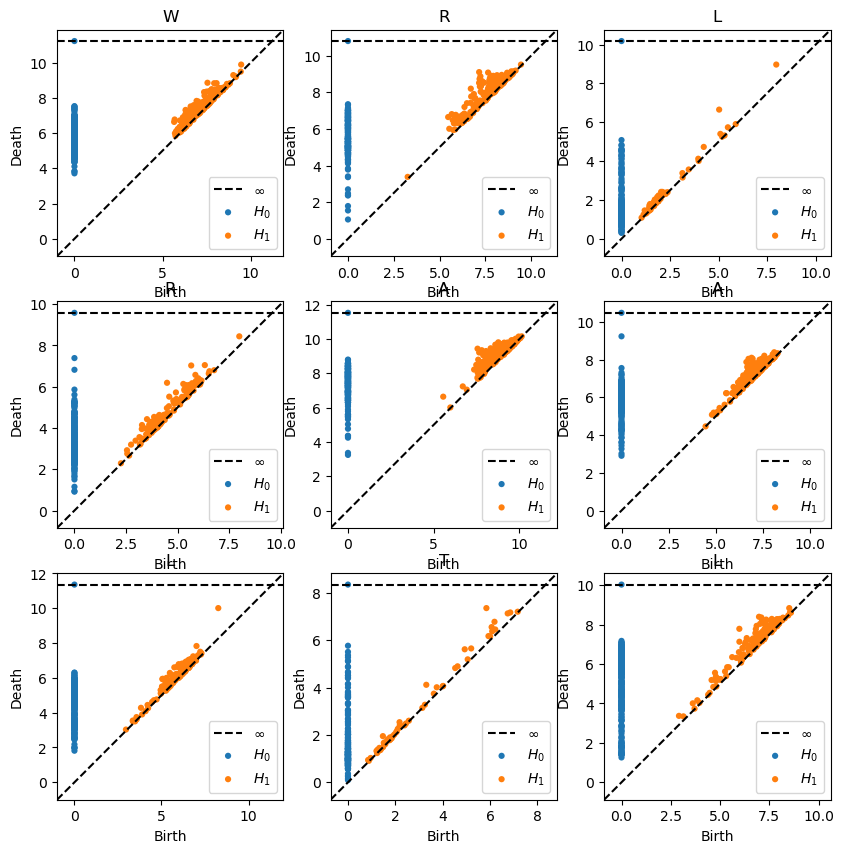

In [37]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    rips.plot(diagrams[i], show=False)
    plt.title(classes[i])
    #plt.axis("off")

In [40]:
pimgr = PersistenceImager(pixel_size=0.25)
pimgr.fit(diagrams_h1)
imgs = pimgr.transform(diagrams_h1)

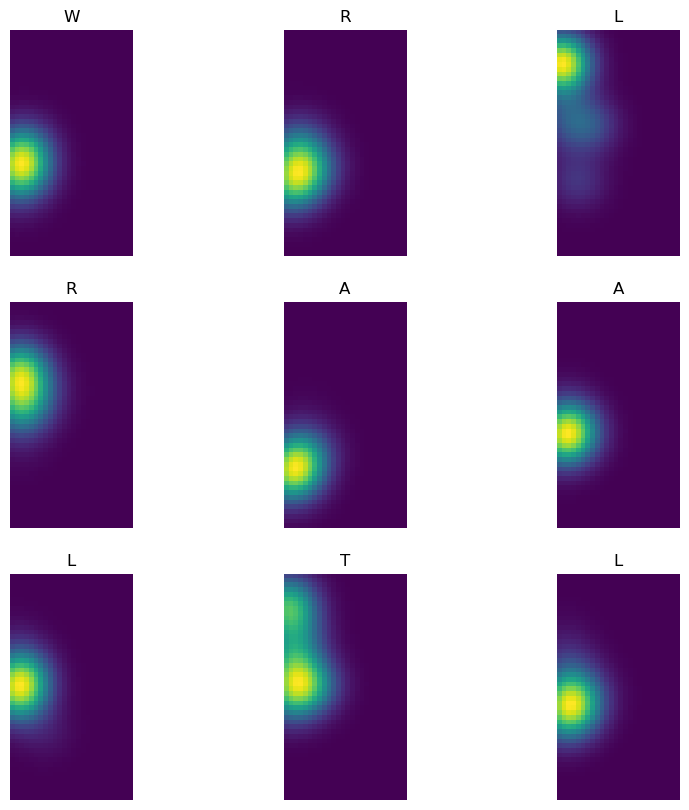

In [41]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i])
    plt.title(classes[i])
    plt.axis("off")

Again, for the five-class classification, we tried different models like XGBoost and SVM ... but they did not give interesting results and it is not useful to mention them here.

In [43]:
imgs_array = np.array([img.flatten() for img in imgs])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array_5c, gender_classes_bi.flatten(), test_size=0.40, random_state=42)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array_5c, np.argmax(classes_bi, axis=1), test_size=0.40, random_state=42)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(imgs_array_5c, np.argmax(classes_bi, axis=1), test_size=0.40, random_state=42)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

LogisticRegression()

In [51]:
lr.score(X_test, y_test)

0.31125

In [54]:
X_train, X_test, y_train, y_test = train_test_split([img.flatten() for img in images], np.argmax(classes_bi, axis=1), test_size=0.33, random_state=42)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


model = XGBClassifier() 
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
predictions = [value for value in y_pred]
accuracy = accuracy_score(y_test, predictions) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[11:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 33.03%
Accuracy: 33.03%


It is not useful for direct classification

## The PersLay model 

### Rips and Alpha diagrams

In [93]:
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

In [15]:


t=1.0
for i in range(8):
    try :
        img = np.random.choice(list(range(len(images_over))))
        img=images[img]*100
        img[img < t] = 0
        rips_complex = gudhi.RipsComplex(points=np.dstack((np.nonzero(img)[0],np.nonzero(img)[1]))[0],
                                    max_edge_length=5) #Pour ne prendre que les points non nuls

        simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
        diag = simplex_tree.persistence(persistence_dim_max=True)
        print(gender_classes_bi_over[img])
        gudhi.plot_persistence_diagram(diag)
        gudhi.plot_persistence_barcode(diag)
        plt.show()
    except:
        continue

Error: Canceled future for execute_request message before replies were done

1


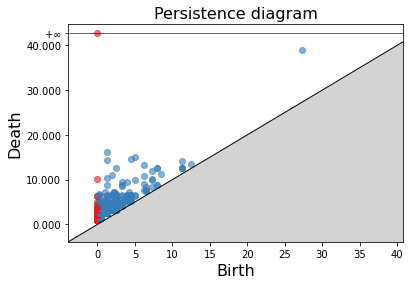

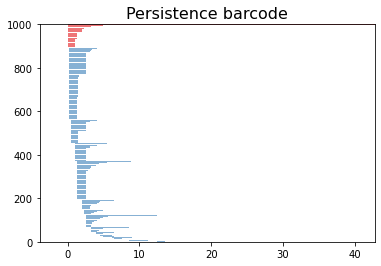

0
0
1


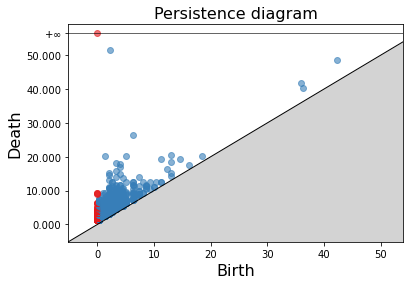

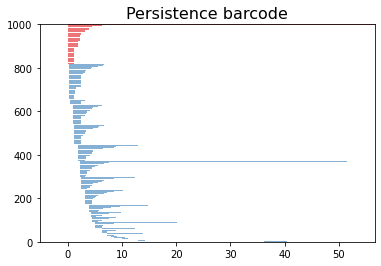

1


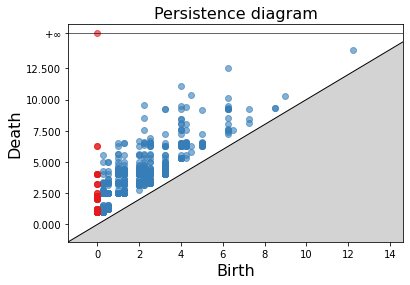

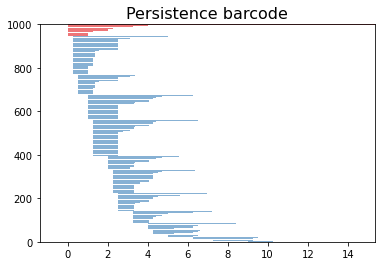

1


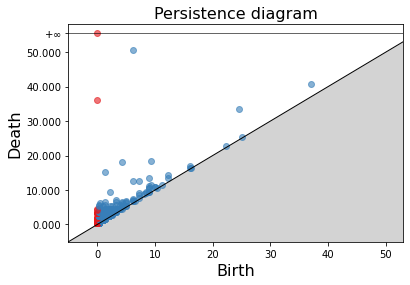

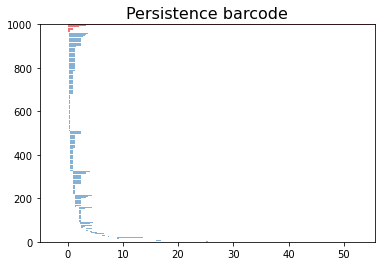

1


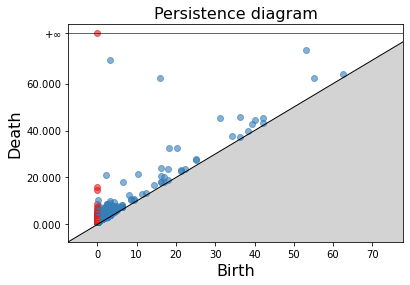

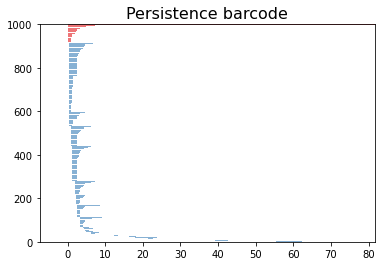

1


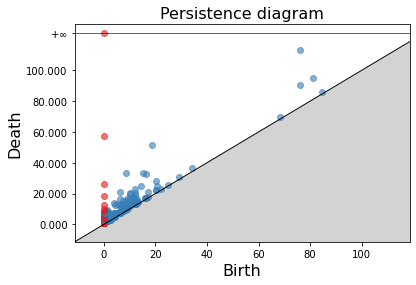

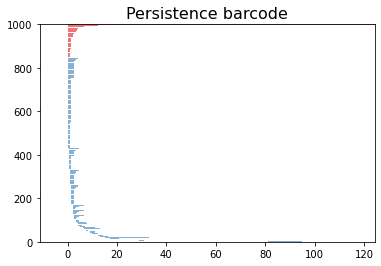

In [9]:
t=1.0
for i in range(8):
    try :
        img = np.random.choice(list(range(len(images_over))))
        print(gender_classes_bi_over[img])
        img=images[img]*100
        img[img < t] = 0
        alpha_complex = gudhi.AlphaComplex(points=np.dstack((np.nonzero(img)[0],np.nonzero(img)[1]))[0],precision = 'fast')
        #Pour ne prendre que les points non nuls
        simplex_tree = alpha_complex.create_simplex_tree()
        diag = simplex_tree.persistence()
        gudhi.plot_persistence_diagram(diag)
        gudhi.plot_persistence_barcode(diag)
        plt.show()
    except:
        continue

We tried to see some rips and alpha diagrams by gudhi, and as it takes a lot of time for the rips diagrams we will use gudhi alpha diagrams and ripser rips diagrams (in the end the diagrams will be tables recognizable by the perslay model).

### Reproduction of the tutorial of the PerslaLay layer (by Mathieu Carrière and Théo Lacombe)

A model for PersLay: a neural network layer for persistence diagrams and other topological signatures (like Betticurves..)

- We have already tried the tutorial done by Carrière and Lacombe using one of their datasets, now we will apply it to the fingerprint dataset. 
- Next, we generate the persistence diagrams 
- Then, we create a model using PersLay channels as the first layers to handle the persistence diagrams. 
- Finally, we train the resulting neural network.

#### Import the required Python packages

Import Numpy, Scikit-learn, TensorFlow, PersLay.

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from tensorflow import random_uniform_initializer as rui
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
from perslay import PerslayModel

### Creation of persistence diagrams


- Persistence diagrams must be given in the following format:
Suppose you have $N$ observations. For each of them, we construct $K$ different persistence diagrams (e.g., persistence diagrams in different homology dimensions, and/or for different filtering, etc.). 

- Then, we must provide a `diags_dict` variable which is a `dictionary`, whose $K$ keys are the names of the types of persistence diagrams (e.g., `"Rips_dim_0"`, `"Cech_dim_1"`)- For each $k_i$ key, $1 \leq i \leq K$, the corresponding value is a `list` of `np.arrays`, each array corresponds to a persistence diagram. 

- Moreover, each list must have the same length $N$ (you must have the same number of persistence diagrams generated for each list).And you must respect the order (i.e. the first element of each list must correspond to the persistence diagram generated with the first observation, and so on).

- Here is an example:

`diags_tmp = {"Alpha0":[np.array([[0.1, 0.2], [0.2, 0.5], [0.3, 0.9]]), np.array([[0.1, 0.4], [0.3, 0.5]]),], "Alpha1":[np.array([[0.1, 0.4], [0.2, 0.6], [0.4, 0.9]]), np.array([[0.1, 0.2], [0.5, 0.7], [0.8, 0.9]])]}`


# RipsComplex and AlphaComplex and storage

__Important note__ : you do not need to recreate the diagrams, you can load them directly.


In [33]:
from progressbar import ProgressBar
pbar = ProgressBar()

In [34]:
def diag_func(diag):
    one_arrays = []
    zero_arrays = []
    for x in diag:
        if x[0]==1 :
            one_arrays.append(list(x[1]))
        if x[0]==0 :
            zero_arrays.append(list(x[1]))
    one_arrays = np.array(one_arrays)
    zero_arrays = np.array(zero_arrays)
    return one_arrays,zero_arrays
        

In [35]:
Alpha_dim_0_diags = []
Alpha_dim_1_diags = [] 
Rips_dim_0_diags = [] 
Rips_dim_1_diags = []
for img in pbar(images_over):
    rips = Rips(maxdim=1, coeff=2, verbose=False)
    diag = rips.fit_transform(img)
    diagrams_h0 = diag[0]
    diagrams_h1 = diag[1]
    cloud2D = np.dstack((np.nonzero(img)[0],np.nonzero(img)[1]))[0]
    alpha_complex = gudhi.AlphaComplex(points=cloud2D,precision = 'fast')
    simplex_tree = alpha_complex.create_simplex_tree()
    diag = simplex_tree.persistence()
    diagrams_h0_a,diagrams_h1_a = diag_func(diag)
    Alpha_dim_0_diags.append(diagrams_h0_a)
    Alpha_dim_1_diags.append(diagrams_h1_a)
    Rips_dim_0_diags.append(diagrams_h0)
    Rips_dim_1_diags.append(diagrams_h1)

100% |########################################################################|


147 minutes needed to generate the diagrams

##### Storing the diagrams
For storage, we tried pickle and np.load and h5py, the first two give files of about 6 gigabytes, so it is not practical.
the last one has a format problem. The best solution is hickle (combination of pickle, and h5py which avoids format and memory problems
)

In [ ]:
import hickle as hkl
# Dump data, with compression
saved_data = (Alpha_dim_0_diags,Alpha_dim_1_diags,Rips_dim_0_diags,Rips_dim_1_diags)
hkl.dump(saved_data, 'saved_Alpha_diags_Rips_diags_for_images_over.hkl', mode='w', compression='gzip')

__Important__ : To load the diagrams :

In [8]:
import hickle as hkl
# Load data
Alpha_dim_0_diags,Alpha_dim_1_diags,Rips_dim_0_diags,Rips_dim_1_diags = hkl.load('saved_Alpha_diags_Rips_diags_for_images_over.hkl')


In [11]:
diags_dict = {"Alpha0":Alpha_dim_0_diags,"Alpha1":Alpha_dim_1_diags,"Rips_dim_0":Rips_dim_0_diags,"Rips_dim_1":Rips_dim_1_diags}

In [12]:
import sys
sys.getsizeof(diags_dict)

232

Now you need to provide the labels for each persistence diagram. 

In [13]:
L = gender_classes_bi_over

We can use some additional "standard" features in your network. These features should be provided as $N \times d$ `np.array`, where $N$ is the number of observations (as before) and $d$ is the feature dimension.
We will not use additional features in this case, we will use an empty array of size $(N,0)$, where $N$ is the number of observations (This is a requirement of the Perslay layer).

In [14]:
N = len(images_over)
F = np.array([[]]*N)


### Preprocessing persistence diagrams

In [15]:
import gudhi.representations as tda

thresh = 1000

# Whole pipeline
tmp = Pipeline([
        ("Selector",      tda.DiagramSelector(use=True, point_type="finite")),
        ("ProminentPts",  tda.ProminentPoints(use=True, num_pts=thresh)),
        ("Scaler",        tda.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())])),
        ("Padding",       tda.Padding(use=True)),
                ])

prm = {filt: {"ProminentPts__num_pts": min(thresh, max([len(dgm) for dgm in diags_dict[filt]]))} 
       for filt in diags_dict.keys() if max([len(dgm) for dgm in diags_dict[filt]]) > 0}

# Apply the previous pipeline on the different filtrations.
diags = []
for dt in prm.keys():
    param = prm[dt]
    tmp.set_params(**param)
    diags.append(tmp.fit_transform(diags_dict[dt]))

# For each filtration, concatenate all diagrams in a single array.
D, npts = [], len(diags[0])
for dt in range(len(prm.keys())):
    D.append(np.array(np.concatenate([diags[dt][i][np.newaxis,:] for i in range(npts)],axis=0),dtype=np.float32))

### Using PersLay in a neural network

### Definition of the network

Initialization of the list of PersLay parameters. This list will contain the different parameters of the PersLay channels (there is one channel per type of filtration/diagram).

In [391]:
perslay_parameters = []

In [392]:
perslay_channel = {}

In [393]:
perslay_channel["pweight_train"] = True
perslay_channel["layer_train"]   = True
perslay_channel["final_model"]   = "identity"

##### Layer type

Choice of layer type, must be one of :
- `"Image"` for a persistence image layer.
- `"PermutationEquivariant"` for a permutation equivariant layer (as in [2]).
- `"Exponential"` for an exponential structure element layer (as in [3]).
- `"Rational"` for a rational structure element layer (as in [3]).
- `"RationalHat"` for a rational hat structure element layer (as in [3]).
- `"Landscape"` for a persistence landscape layer.
- `"BettiCurve"` for a Betti curve layer.
- `"Entropy"` for a persistence entropy layer.

In [394]:
perslay_channel["layer"]           = "Landscape"
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 

In [371]:
perslay_channel["layer"]           = "Image"
perslay_channel["image_size"]      = (20, 20)
perslay_channel["image_bnds"]      = ((-.001, 1.001), (-.001, 1.001))
perslay_channel["lvariance_init"]  = 3.

In [ ]:
perslay_channel["layer"]           = "PermutationEquivariant"
perslay_channel["lpeq"]            = [(5, "max")]
perslay_channel["lweight_init"]    = rui(0.0, 1.0)
perslay_channel["lbias_init"]      = rui(0.0, 1.0)
perslay_channel["lgamma_init"]     = rui(0.0, 1.0)

In [386]:
perslay_channel["layer"]           = "Exponential"
perslay_channel["lnum"]            = 25
perslay_channel["lmean_init"]      = rui(0.0, 1.0)
perslay_channel["lvariance_init"]  = rui(3.0, 3.0)

In [ ]:
perslay_channel["layer"]           = "Rational"
perslay_channel["lnum"]            = 25
perslay_channel["lmean_init"]      = rui(0.0, 1.0)
perslay_channel["lvariance_init"]  = rui(3.0, 3.0) 
perslay_channel["lalpha_init"]     = rui(3.0, 3.0) 

In [ ]:
perslay_channel["layer"]           = "RationalHat"
perslay_channel["lnum"]            = 25
perslay_channel["lmean_init"]      = rui(0.0, 1.0)
perslay_channel["lr_init"]         = rui(3.0, 3.0) 
perslay_channel["q"]               = 2

In [356]:
perslay_channel["layer"]           = "BettiCurve"
perslay_channel["theta"]           = 10
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 

In [ ]:
perslay_channel["layer"]           = "Entropy"
perslay_channel["theta"]           = 10
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 

##### Weight function

Choice of weight function, must be one of :
- `"power"`, for the distance to the diagonal with some exponent.
- `"grid"`, for a piecewise-constant function defined with pixel values.
- `"gmix"`, for a weight function defined as a mixture of Gaussians.
- `None`, for a constant weight function. 

In [387]:
perslay_channel["pweight"]       = "power"
perslay_channel["pweight_init"]  = 1.
perslay_channel["pweight_power"] = 1

In [ ]:
perslay_channel["pweight"]       = "grid"
perslay_channel["pweight_size"]  = [20,20]
perslay_channel["pweight_bnds"]  = ((-.001, 1.001), (-.001, 1.001))
perslay_channel["pweight_init"]  = rui(1.0, 1.0)

In [395]:
perslay_channel["pweight"]       = "gmix"
perslay_channel["pweight_num"]   = 3
perslay_channel["pweight_init"]  = np.array(np.vstack([np.random.uniform(0.,1.,[2,3]), 
                                                        5.*np.ones([2,3])]), dtype=np.float32)

In [ ]:
perslay_channel["pweight"]       = None

##### Permutation-invariant operation


Choice of the permutation invariant operator, must be one of :

- `"sum"`.
- `"topk"`, will select the $k$ highest values, specified in `keep`.
- `"max"`.
- `"mean"`.

In [396]:
perslay_channel["perm_op"] = "sum"

In [ ]:
perslay_channel["perm_op"] = "topk"
perslay_channel["keep"]    = 5

In [343]:
perslay_channel["perm_op"] = "max"

In [373]:
perslay_channel["perm_op"] = "mean"

##### Definition of the model and choice of the optimizer, the loss and the metric.

######  Choice of parameters:

We have tried many examples, and we will make a search grid later, but for now, as a first attempt, we use :
layer : Landscape
pweight : power
perm_op : mean


the results presented below correspond to this one

In [397]:
perslay_parameters = [perslay_channel for _ in range(len(D))]

In [398]:
import tensorflow_addons as tfa

## Train the network

In [408]:
rho = tf.keras.Sequential([tf.keras.layers.Dense(1, activation="sigmoid")])
model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [409]:
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train, y_test = train_test_split(D[0], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train1, X_test1, y_train, y_test = train_test_split(D[1], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train2, X_test2, y_train, y_test = train_test_split(D[2], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train3, X_test3, y_train, y_test = train_test_split(D[3], gender_classes_bi_over, test_size=0.3, random_state=69)
feats_train, feats_test, y_train, y_test = train_test_split(F, gender_classes_bi_over, test_size=0.3, random_state=69)

In [410]:
diags_train = [X_train0,X_train1,X_train2,X_train3]
diags_test = [X_test0,X_test1,X_test2,X_test3]

In [415]:
history = model.fit(x=[diags_train, feats_train], y=y_train, validation_data=([diags_test, feats_test], y_test), epochs=100, batch_size=128, shuffle=True, verbose=1)


Epoch 1/100
36/36 [==============================] - 16s 447ms/step - loss: 0.4799 - accuracy: 0.7833 - val_loss: 0.4959 - val_accuracy: 0.7723
Epoch 2/100
36/36 [==============================] - 16s 449ms/step - loss: 0.4793 - accuracy: 0.7833 - val_loss: 0.4938 - val_accuracy: 0.7759
Epoch 3/100
36/36 [==============================] - 16s 447ms/step - loss: 0.4797 - accuracy: 0.7813 - val_loss: 0.4946 - val_accuracy: 0.7713
Epoch 4/100
36/36 [==============================] - 16s 448ms/step - loss: 0.4744 - accuracy: 0.7855 - val_loss: 0.5138 - val_accuracy: 0.7636
Epoch 5/100
36/36 [==============================] - 16s 442ms/step - loss: 0.4752 - accuracy: 0.7884 - val_loss: 0.4902 - val_accuracy: 0.7856
Epoch 6/100
36/36 [==============================] - 16s 442ms/step - loss: 0.4781 - accuracy: 0.7793 - val_loss: 0.4919 - val_accuracy: 0.7774
Epoch 7/100
36/36 [==============================] - 16s 449ms/step - loss: 0.4734 - accuracy: 0.7855 - val_loss: 0.4890 - val_accuracy:

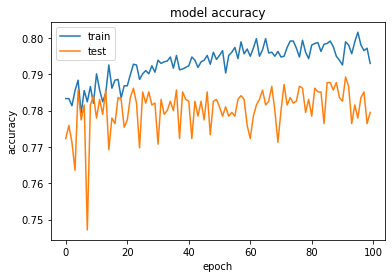

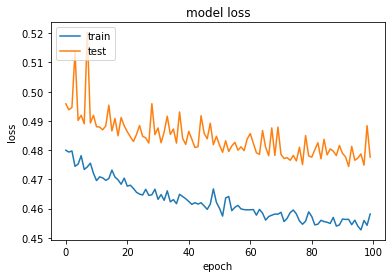

In [416]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [413]:
model.summary()

Model: "perslay_model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_23 (Sequential)  (None, 1)                 401       
                                                                 
Total params: 849
Trainable params: 849
Non-trainable params: 0
_________________________________________________________________


In [414]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Second test with BettiCurve

In [44]:
perslay_parameters = []
perslay_channel = {}
perslay_channel["pweight_train"] = True
perslay_channel["layer_train"]   = True
perslay_channel["final_model"]   = "identity"

In [45]:
perslay_channel["layer"]           = "BettiCurve"
perslay_channel["theta"]           = 10
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 

In [46]:
perslay_channel["pweight"]       = "power"
perslay_channel["pweight_init"]  = 1.
perslay_channel["pweight_power"] = 1

In [47]:
perslay_channel["perm_op"] = "sum"

In [48]:
perslay_parameters = [perslay_channel for _ in range(len(D))]

In [51]:
rho = tf.keras.Sequential([tf.keras.layers.Dense(1, activation="sigmoid")])
model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [430]:
history = model.fit(x=[diags_train, feats_train], y=y_train, validation_data=([diags_test, feats_test], y_test), epochs=20, batch_size=128, shuffle=True, verbose=1)


Epoch 1/20
36/36 [==============================] - 22s 583ms/step - loss: 22.6293 - accuracy: 0.5119 - val_loss: 4.7371 - val_accuracy: 0.5313
Epoch 2/20
36/36 [==============================] - 20s 548ms/step - loss: 1.9880 - accuracy: 0.5758 - val_loss: 0.9908 - val_accuracy: 0.6241
Epoch 3/20
36/36 [==============================] - 20s 566ms/step - loss: 0.8704 - accuracy: 0.5747 - val_loss: 0.7310 - val_accuracy: 0.5677
Epoch 4/20
36/36 [==============================] - 19s 536ms/step - loss: 0.6938 - accuracy: 0.6037 - val_loss: 0.6668 - val_accuracy: 0.6195
Epoch 5/20
36/36 [==============================] - 19s 531ms/step - loss: 0.6621 - accuracy: 0.6191 - val_loss: 0.6287 - val_accuracy: 0.6344
Epoch 6/20
36/36 [==============================] - 19s 533ms/step - loss: 0.6086 - accuracy: 0.6673 - val_loss: 0.5993 - val_accuracy: 0.6682
Epoch 7/20
36/36 [==============================] - 20s 562ms/step - loss: 0.5941 - accuracy: 0.6855 - val_loss: 0.5916 - val_accuracy: 0.706

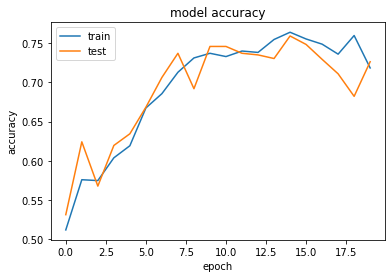

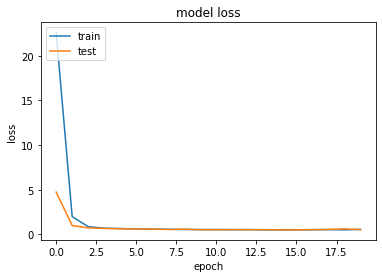

In [431]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Gridsearch for a first and quick comparison of the parameters.

In [52]:
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train, y_test = train_test_split(D[0], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train1, X_test1, y_train, y_test = train_test_split(D[1], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train2, X_test2, y_train, y_test = train_test_split(D[2], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train3, X_test3, y_train, y_test = train_test_split(D[3], gender_classes_bi_over, test_size=0.3, random_state=69)
feats_train, feats_test, y_train, y_test = train_test_split(F, gender_classes_bi_over, test_size=0.3, random_state=69)
diags_train = [X_train0,X_train1,X_train2,X_train3]
diags_test = [X_test0,X_test1,X_test2,X_test3]

In [53]:
histories =[]
models=[]
for optimizer in ["RMSprop","Nadam","adam"]:  
        perslay_parameters = []
        perslay_channel = {}
        perslay_channel["pweight_train"] = True
        perslay_channel["layer_train"]   = True
        perslay_channel["final_model"]   = "identity"
        for layer in ["BettiCurve","PermutationEquivariant","Exponential","Landscape"]:
            print(optimizer,layer)
            if layer =="BettiCurve":
                perslay_channel["layer"]           = "BettiCurve"
                perslay_channel["theta"]           = 10
                perslay_channel["lsample_num"]     = 100
                perslay_channel["lsample_init"]    = rui(0.0, 1.0) 
            if layer =="PermutationEquivariant":
                perslay_channel["layer"]           = "PermutationEquivariant"
                perslay_channel["lpeq"]            = [(5, "max")]
                perslay_channel["lweight_init"]    = rui(0.0, 1.0)
                perslay_channel["lbias_init"]      = rui(0.0, 1.0)
                perslay_channel["lgamma_init"]     = rui(0.0, 1.0)
            if layer =="Exponential":
                perslay_channel["layer"]           = "Exponential"
                perslay_channel["lnum"]            = 25
                perslay_channel["lmean_init"]      = rui(0.0, 1.0)
                perslay_channel["lvariance_init"]  = rui(3.0, 3.0)
            if layer =="Landscape":
                perslay_channel["layer"]           = "Landscape"
                perslay_channel["lsample_num"]     = 100
                perslay_channel["lsample_init"]    = rui(0.0, 1.0) 

            for pweight in ["power","grid","gmix","None"]:
                if pweight =="power":
                    perslay_channel["pweight"]       = "power"
                    perslay_channel["pweight_init"]  = 1.
                    perslay_channel["pweight_power"] = 1
                if pweight =="grid":
                    perslay_channel["pweight"]       = "grid"
                    perslay_channel["pweight_size"]  = [20,20]
                    perslay_channel["pweight_bnds"]  = ((-.001, 1.001), (-.001, 1.001))
                    perslay_channel["pweight_init"]  = rui(1.0, 1.0)
                if pweight =="gmix":
                    perslay_channel["pweight"]       = "gmix"
                    perslay_channel["pweight_num"]   = 3
                    perslay_channel["pweight_init"]  = np.array(np.vstack([np.random.uniform(0.,1.,[2,3]), 
                                                                            5.*np.ones([2,3])]), dtype=np.float32)
                if pweight =="None":
                    perslay_channel["pweight"]       = None

                for perm_op in ["perm_op","topk","max"]:
                    if perm_op =="perm_op":
                        perslay_channel["perm_op"] = "sum"
                    if perm_op =="topk":
                        perslay_channel["perm_op"] = "topk"
                        perslay_channel["keep"]    = 10
                    if perm_op =="max":
                        perslay_channel["perm_op"] = "max"
                    if (optimizer,perm_op,pweight,layer) in [('RMSprop', 'perm_op', 'power', 'Exponential')]:
                        continue  
                    try:
                        perslay_parameters = [perslay_channel for _ in range(len(D))]
                        rho = tf.keras.Sequential([tf.keras.layers.Dense(1, activation="sigmoid")])
                        model = None
                        model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
                        model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
                        history = model.fit(x=[diags_train, feats_train], y=y_train, validation_data=([diags_test, feats_test], y_test), epochs=5, batch_size=32, shuffle=True, verbose=0)
                        histories.append(history)
                        models.append(model)
                    except :
                        print(optimizer,perm_op,pweight,layer)


RMSprop BettiCurve
RMSprop PermutationEquivariant
RMSprop Exponential
RMSprop topk power Exponential
RMSprop max power Exponential
RMSprop perm_op grid Exponential
RMSprop topk grid Exponential
RMSprop max grid Exponential
RMSprop perm_op gmix Exponential
RMSprop topk gmix Exponential
RMSprop max gmix Exponential
RMSprop perm_op None Exponential
RMSprop topk None Exponential
RMSprop max None Exponential
RMSprop Landscape
Nadam BettiCurve
Nadam PermutationEquivariant
Nadam Exponential
Nadam perm_op power Exponential
Nadam topk power Exponential
Nadam max power Exponential
Nadam perm_op grid Exponential
Nadam topk grid Exponential
Nadam max grid Exponential
Nadam perm_op gmix Exponential
Nadam topk gmix Exponential
Nadam max gmix Exponential
Nadam perm_op None Exponential
Nadam topk None Exponential
Nadam max None Exponential
Nadam Landscape
adam BettiCurve
adam PermutationEquivariant
adam Exponential
adam perm_op power Exponential
adam topk power Exponential
adam max power Exponential
a

In [60]:
models_names =[]
for optimizer in ["RMSprop","Nadam","adam"]:  
        for layer in ["BettiCurve","PermutationEquivariant","Landscape"]:
            for pweight in ["power","grid","gmix","None"]:
                for perm_op in ["perm_op","topk","max"]:
                    models_names.append(optimizer+"_"+perm_op+"_"+pweight+"_"+layer)



In [63]:
len(models_names)==len(histories)

True

In [77]:
models_description1

{'RMSprop_perm_op_power_BettiCurve': 0.5727179408073425,
 'RMSprop_topk_power_BettiCurve': 0.7136410117149353,
 'RMSprop_max_power_BettiCurve': 0.6602051377296447,
 'RMSprop_perm_op_grid_BettiCurve': 0.5457435786724091,
 'RMSprop_topk_grid_BettiCurve': 0.6672820568084716,
 'RMSprop_max_grid_BettiCurve': 0.6867692351341248,
 'RMSprop_perm_op_gmix_BettiCurve': 0.690666663646698,
 'RMSprop_topk_gmix_BettiCurve': 0.6967179417610169,
 'RMSprop_max_gmix_BettiCurve': 0.6937435865402222,
 'RMSprop_perm_op_None_BettiCurve': 0.6019487261772156,
 'RMSprop_topk_None_BettiCurve': 0.6402051210403442,
 'RMSprop_max_None_BettiCurve': 0.6870769381523132,
 'RMSprop_perm_op_power_PermutationEquivariant': 0.5129230797290802,
 'RMSprop_topk_power_PermutationEquivariant': 0.7005128145217896,
 'RMSprop_max_power_PermutationEquivariant': 0.5300512790679932,
 'RMSprop_perm_op_grid_PermutationEquivariant': 0.5668717861175537,
 'RMSprop_topk_grid_PermutationEquivariant': 0.6551794886589051,
 'RMSprop_max_grid_Pe

In [94]:
models_description1 = dict(zip(models_names, [np.mean(histo.history['val_accuracy']) for histo in histories]))
models_description2 = dict(zip(models_names, [np.max(histo.history['val_accuracy']) for histo in histories]))
models_description1 = pd.Series(models_description1)
models_description2 = pd.Series(models_description2)
df_models = pd.concat([models_description1,models_description2], axis=1)
df_models = df_models.rename(columns={0: "mean", 1: "max"})
df_models = df_models.reset_index()
df_models.head()

,index,mean,max
0,RMSprop_perm_op_power_BettiCurve,0.572718,0.629744
1,RMSprop_topk_power_BettiCurve,0.713641,0.774872
2,RMSprop_max_power_BettiCurve,0.660205,0.666154
3,RMSprop_perm_op_grid_BettiCurve,0.545744,0.694872
4,RMSprop_topk_grid_BettiCurve,0.667282,0.706154


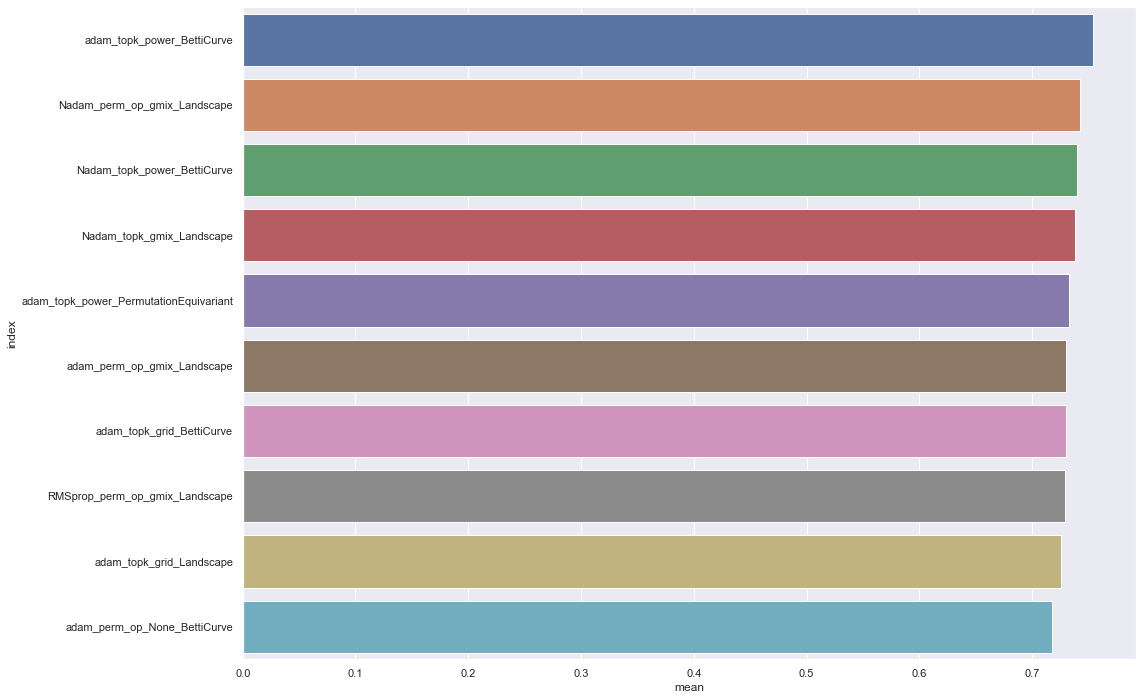

In [96]:
plt.figure(figsize=(16, 12))
sns.barplot(data=df_models.sort_values(by='mean', ascending=False).head(10),x='mean', y='index');
plt.show();


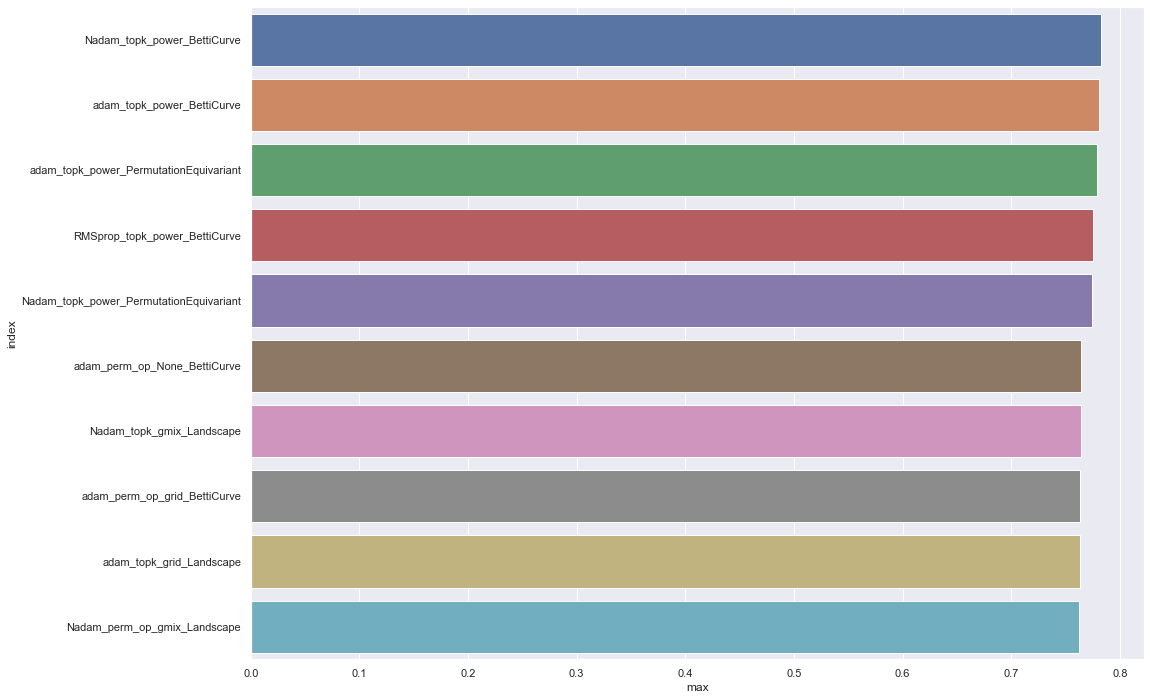

In [97]:
plt.figure(figsize=(16, 12))
sns.barplot(data=df_models.sort_values(by='max', ascending=False).head(10),x='max', y='index');
plt.show();

In [465]:
optimizer,perm_op,pweight,layer

('RMSprop', 'perm_op', 'power', 'Exponential')

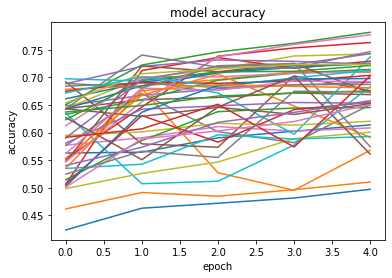

In [462]:
for history in histories:
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='upper left')
plt.show()


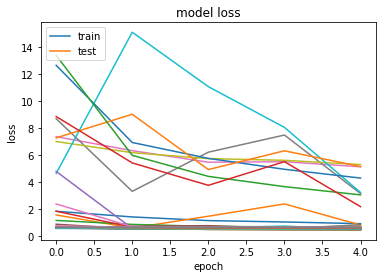

In [464]:

for history in histories:
    # summarize history for accuracy
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    #plt.legend(['train', 'test'], loc='upper left')
plt.show()# summarize history for loss


In [37]:
#nqd topk poer betticurve
# best one

In [38]:
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train, y_test = train_test_split(D[0], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train1, X_test1, y_train, y_test = train_test_split(D[1], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train2, X_test2, y_train, y_test = train_test_split(D[2], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train3, X_test3, y_train, y_test = train_test_split(D[3], gender_classes_bi_over, test_size=0.3, random_state=69)
feats_train, feats_test, y_train, y_test = train_test_split(F, gender_classes_bi_over, test_size=0.3, random_state=69)
diags_train = [X_train0,X_train1,X_train2,X_train3]
diags_test = [X_test0,X_test1,X_test2,X_test3]

In [39]:
optimizer = "Nadam"
perslay_parameters = []
perslay_channel = {}
perslay_channel["pweight_train"] = True
perslay_channel["layer_train"]   = True
perslay_channel["final_model"]   = "identity"
perslay_channel["layer"]           = "BettiCurve"
perslay_channel["theta"]           = 10
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 
perslay_channel["pweight"]       = "power"
perslay_channel["pweight_init"]  = 1.
perslay_channel["pweight_power"] = 1
perslay_channel["perm_op"] = "topk"
perslay_channel["keep"]    = 10

perslay_parameters = [perslay_channel for _ in range(len(D))]
rho = tf.keras.Sequential([tf.keras.layers.Dense(1, activation="sigmoid")])
model = None
model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = model.fit(x=[diags_train, feats_train], y=y_train, validation_data=([diags_test, feats_test], y_test), epochs=30, batch_size=64, shuffle=True, verbose=1)

Epoch 1/30
72/72 [==============================] - 28s 329ms/step - loss: 0.5187 - accuracy: 0.7596 - val_loss: 0.4944 - val_accuracy: 0.7615
Epoch 2/30
72/72 [==============================] - 23s 316ms/step - loss: 0.4474 - accuracy: 0.8077 - val_loss: 0.4387 - val_accuracy: 0.8092
Epoch 3/30
72/72 [==============================] - 23s 316ms/step - loss: 0.4309 - accuracy: 0.8141 - val_loss: 0.4284 - val_accuracy: 0.8256
Epoch 4/30
72/72 [==============================] - 23s 326ms/step - loss: 0.4224 - accuracy: 0.8167 - val_loss: 0.4229 - val_accuracy: 0.8272
Epoch 5/30
72/72 [==============================] - 23s 322ms/step - loss: 0.4140 - accuracy: 0.8178 - val_loss: 0.4124 - val_accuracy: 0.8205
Epoch 6/30
72/72 [==============================] - 23s 316ms/step - loss: 0.4089 - accuracy: 0.8209 - val_loss: 0.4219 - val_accuracy: 0.8221
Epoch 7/30
72/72 [==============================] - 23s 320ms/step - loss: 0.4059 - accuracy: 0.8204 - val_loss: 0.4331 - val_accuracy: 0.8246

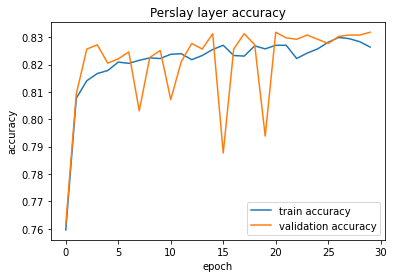

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(history.history['accuracy'],label="train accuracy")
plt.plot(history.history['val_accuracy'],label="validation accuracy")
plt.title('Perslay layer accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
plt.savefig('Perslay_1_layer_accuracy.png')

In [41]:
np.max(history.history['val_accuracy'])

0.8317948579788208

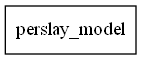

In [50]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Now we use Perslay but with images as features :

In [61]:
optimizer = "Nadam"
perslay_parameters = []
perslay_channel = {}

#perslay_channel["pweight"]       = "power"
#perslay_channel["pweight_init"]  = 1.
#perslay_channel["pweight_power"] = 1
#perslay_channel["perm_op"] = "topk"
#perslay_channel["keep"]    = 10


perslay_channel["layer_train"]    = True
perslay_channel["layer"]           = "BettiCurve"
perslay_channel["theta"]           = 10
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 
perslay_channel["pweight"]        = "grid"
perslay_channel["pweight_init"]   = rui(1., 1.)
perslay_channel["pweight_size"]   = (10, 10)
perslay_channel["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
perslay_channel["pweight_train"]  = True
perslay_channel["perm_op"]        = "sum"

# fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu"),
# tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu"),
# tf.keras.layers.Flatten()])
#perslay_channel["final_model"]   = fmodel

perslay_parameters = [perslay_channel for _ in range(len(D))]




# optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
# optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
# loss = tf.keras.losses.CategoricalCrossentropy()
# metrics = [tf.keras.metrics.CategoricalAccuracy()]

for i in range(len(D)):
    fmodel =  tf.keras.Sequential([ 
    tf.keras.layers.Dense(64,activation='relu')])
    perslay_parameters[i]["final_model"] = fmodel


rho = tf.keras.Sequential([tf.keras.layers.Dense(1, activation="sigmoid")]) #2
model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])


In [31]:
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train, y_test = train_test_split(D[0], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train1, X_test1, y_train, y_test = train_test_split(D[1], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train2, X_test2, y_train, y_test = train_test_split(D[2], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train3, X_test3, y_train, y_test = train_test_split(D[3], gender_classes_bi_over, test_size=0.3, random_state=69)
feats_train, feats_test, y_train, y_test = train_test_split( np.array([img.flatten() for img in images_over]), gender_classes_bi_over, test_size=0.3, random_state=69)
diags_train = [X_train0,X_train1,X_train2,X_train3]
diags_test = [X_test0,X_test1,X_test2,X_test3]

In [35]:
optimizer = "Nadam"

perslay_parameters = []
perslay_channel = {}
perslay_channel["pweight"]        = "grid"
perslay_channel["pweight_init"]   = rui(1., 1.)
perslay_channel["pweight_size"]   = (10, 10)
perslay_channel["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
perslay_channel["pweight_train"]  = True
perslay_channel["layer"]          = "Image"
perslay_channel["image_size"]     = (20, 20)
perslay_channel["image_bnds"]     = ((-0.001, 1.001), (-0.001, 1.001))
perslay_channel["lvariance_init"] = rui(3., 3.)
perslay_channel["layer_train"]    = True
perslay_channel["perm_op"]        = "sum"
perslay_parameters = [perslay_channel for _ in range(len(D))]


for i in range(len(D)):
    fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(10, 2, input_shape=(21,21,1)), tf.keras.layers.Flatten()])
    perslay_parameters[i]["final_model"] = fmodel
rho = tf.keras.Sequential([tf.keras.layers.Dense(1, activation="sigmoid", input_shape=(16000+feats_train.shape[1],))])#1



model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [36]:
history = model.fit(x=[diags_train, feats_train], y=y_train, validation_data=([diags_test, feats_test], y_test), epochs=30, batch_size=64, shuffle=True, verbose=1)

Epoch 1/30
72/72 [==============================] - 122s 2s/step - loss: 4.4309 - accuracy: 0.6767 - val_loss: 7.0923 - val_accuracy: 0.5467
Epoch 2/30
72/72 [==============================] - 116s 2s/step - loss: 2.7727 - accuracy: 0.7418 - val_loss: 17.4258 - val_accuracy: 0.5046
Epoch 3/30
72/72 [==============================] - 113s 2s/step - loss: 2.0145 - accuracy: 0.7800 - val_loss: 1.9179 - val_accuracy: 0.7574
Epoch 4/30
72/72 [==============================] - 116s 2s/step - loss: 1.9850 - accuracy: 0.7736 - val_loss: 0.9212 - val_accuracy: 0.8462
Epoch 5/30
72/72 [==============================] - 115s 2s/step - loss: 1.6162 - accuracy: 0.7930 - val_loss: 1.5649 - val_accuracy: 0.7826
Epoch 6/30
72/72 [==============================] - 115s 2s/step - loss: 1.1673 - accuracy: 0.8097 - val_loss: 0.7900 - val_accuracy: 0.8282
Epoch 7/30
72/72 [==============================] - 117s 2s/step - loss: 1.2109 - accuracy: 0.8297 - val_loss: 0.7305 - val_accuracy: 0.8426
Epoch 8/30
7

In [37]:
np.max(history.history['val_accuracy'])

0.8538461327552795

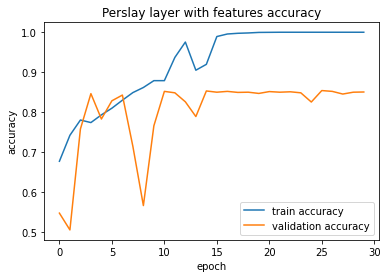

<Figure size 432x288 with 0 Axes>

In [39]:
plt.plot(history.history['accuracy'],label="train accuracy")
plt.plot(history.history['val_accuracy'],label="validation accuracy")
plt.title('Perslay layer with features accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
plt.savefig('Perslay_with_features_layer_accuracy.png')

In [ ]:
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train, y_test = train_test_split(D[0], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train1, X_test1, y_train, y_test = train_test_split(D[1], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train2, X_test2, y_train, y_test = train_test_split(D[2], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train3, X_test3, y_train, y_test = train_test_split(D[3], gender_classes_bi_over, test_size=0.3, random_state=69)
feats_train, feats_test, y_train, y_test = train_test_split( np.array([img.flatten() for img in images_over]), gender_classes_bi_over, test_size=0.3, random_state=69)
diags_train = [X_train0,X_train1,X_train2,X_train3]
diags_test = [X_test0,X_test1,X_test2,X_test3]

In [ ]:


perslay_parameters = []
perslay_channel = {}
perslay_channel["pweight_train"] = True
perslay_channel["layer_train"]   = True

perslay_channel["layer"]           = "BettiCurve"
perslay_channel["theta"]           = 10
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 
perslay_channel["pweight"]       = "power"
perslay_channel["pweight_init"]  = 1.
perslay_channel["pweight_power"] = 1
perslay_channel["perm_op"] = "topk"
perslay_channel["keep"]    = 10


# fmodel = tf.keras.Sequential([tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu"),
# tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu"),
# tf.keras.layers.Flatten()])
#perslay_channel["final_model"]   = fmodel
perslay_parameters = [perslay_channel for _ in range(len(D))]


for i in range(len(D)):
    fmodel =  tf.keras.Sequential([ tf.keras.layers.Conv2D(kernel_size=(4,4), filters=32, activation='selu'),
    tf.keras.layers.MaxPool2D(5,5),
    tf.keras.layers.Conv2D(filters=64,kernel_size = (3,3),activation='selu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(filters=128,kernel_size = (3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu')])
    perslay_parameters[i]["final_model"] = fmodel

rho = tf.keras.Sequential([tf.keras.layers.Dense(1, activation="sigmoid")]) #2
model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [57]:
input_images = Input(shape=(256, 256,1,))
x = Conv2D(kernel_size=(4,4), filters=32, activation='selu')(input_images)
x = MaxPool2D(5,5)(x)
x = Conv2D(filters=64,kernel_size = (3,3),activation='selu')(x)
x = MaxPool2D(2,2)(x)
x = Conv2D(filters=128,kernel_size = (3,3),activation='relu')(x)
x = MaxPool2D(2,2)(x)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = Model(inputs=input_images, outputs=x)

#second model #two options (images or not)
input_features = Input(shape=(84,))
y = Dense(84,activation='relu')(input_features)
y = Dense(64,activation='relu')(y)
y = Model(inputs=input_features, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs




z = Dense(32,activation=tf.keras.layers.LeakyReLU(alpha=0.3))(combined)
z = Dropout(0.2)(z)
z= Dense(1,activation = 'sigmoid')(z)
model_66 = Model(inputs=[x.input, y.input], outputs=z)

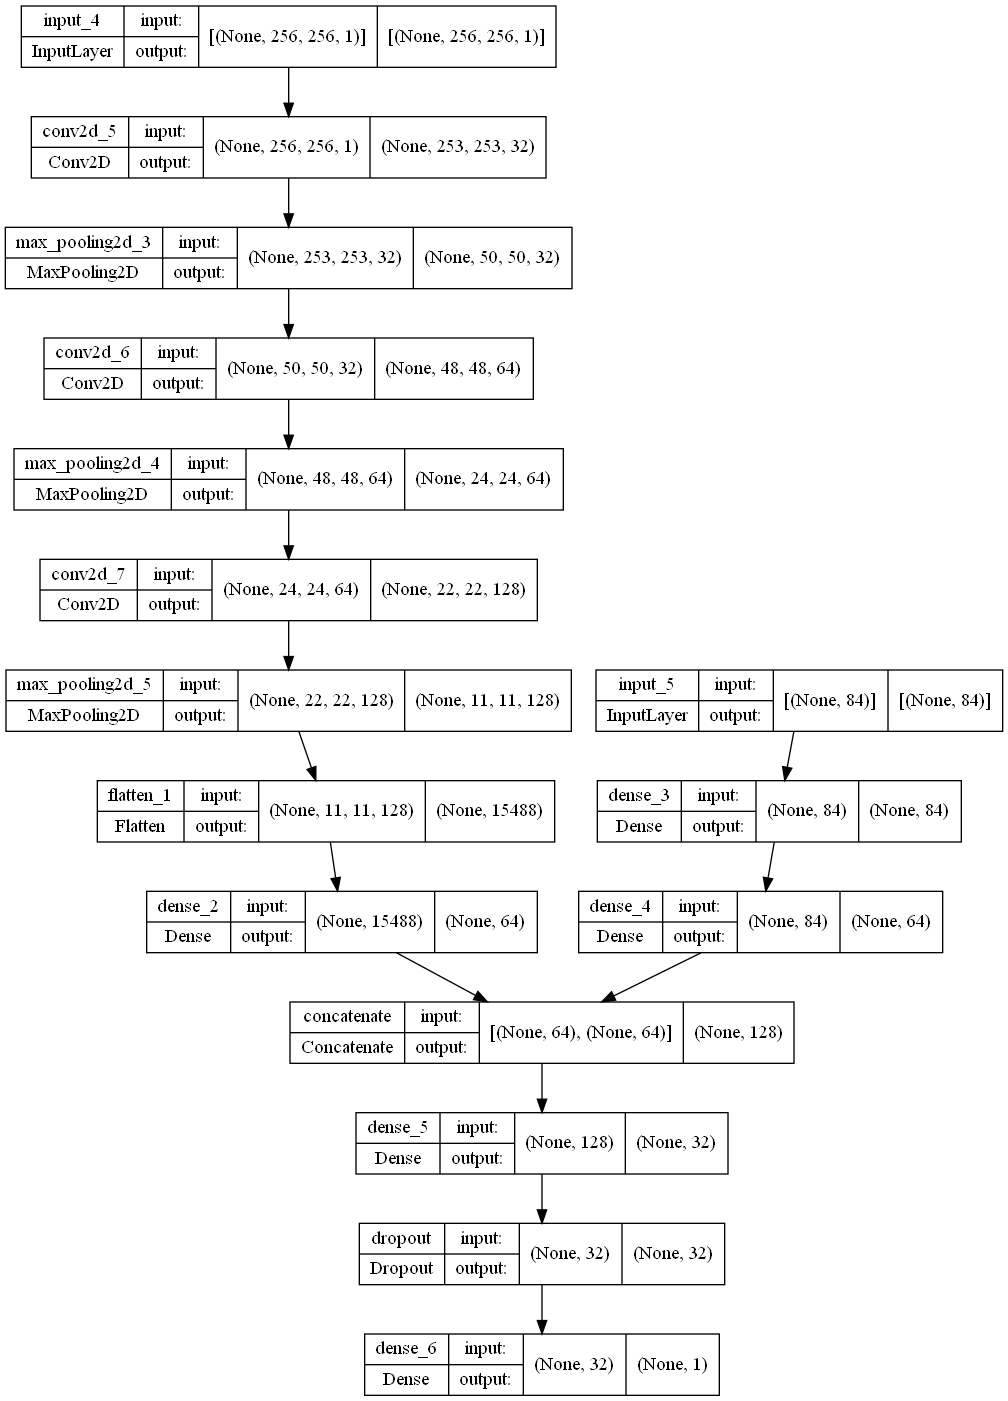

In [58]:
from keras.utils.vis_utils import plot_model
plot_model(model_66, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [59]:
model_66.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 253, 253, 32  544         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 50, 50, 32)  0           ['conv2d_5[0][0]']               
                                                                                            

In [ ]:
# to continue (last result is adding PersLay as a feature augmentation method)

In [16]:
F = np.array([img.flatten() for img in images_over])

In [45]:
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train, y_test = train_test_split(D[0], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train1, X_test1, y_train, y_test = train_test_split(D[1], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train2, X_test2, y_train, y_test = train_test_split(D[2], gender_classes_bi_over, test_size=0.3, random_state=69)
X_train3, X_test3, y_train, y_test = train_test_split(D[3], gender_classes_bi_over, test_size=0.3, random_state=69)
feats_train, feats_test, y_train, y_test = train_test_split(F, gender_classes_bi_over, test_size=0.3, random_state=69)
# Images_train, Images_test, y_train, y_test = train_test_split(F, gender_classes_bi_over, test_size=0.3, random_state=69)

diags_train = [X_train0,X_train1,X_train2,X_train3]
diags_test = [X_test0,X_test1,X_test2,X_test3]

In [46]:
optimizer = "Nadam"
perslay_parameters = []
perslay_channel = {}
perslay_channel["pweight_train"] = True
perslay_channel["layer_train"]   = True
perslay_channel["final_model"]   = "identity"
perslay_channel["layer"]           = "BettiCurve"
perslay_channel["theta"]           = 10
perslay_channel["lsample_num"]     = 100
perslay_channel["lsample_init"]    = rui(0.0, 1.0) 
perslay_channel["pweight"]       = "power"
perslay_channel["pweight_init"]  = 1.
perslay_channel["pweight_power"] = 1
perslay_channel["perm_op"] = "topk"
perslay_channel["keep"]    = 10

perslay_parameters = [perslay_channel for _ in range(len(D))]


In [34]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [47]:
rho = tf.keras.Sequential([tf.keras.layers.Dense(1, activation="sigmoid")])
model = None
model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)

In [48]:
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = model.fit(x=[diags_train, feats_train], y=y_train, validation_data=([diags_test, feats_test], y_test), epochs=30, batch_size=32, shuffle=True, verbose=1)

Epoch 1/30
143/143 [==============================] - 30s 182ms/step - loss: 1.8436 - accuracy: 0.7033 - val_loss: 1.0961 - val_accuracy: 0.7831
Epoch 2/30
143/143 [==============================] - 27s 190ms/step - loss: 1.6356 - accuracy: 0.7585 - val_loss: 1.4003 - val_accuracy: 0.7518
Epoch 3/30
143/143 [==============================] - 28s 199ms/step - loss: 1.1831 - accuracy: 0.8009 - val_loss: 0.9957 - val_accuracy: 0.8067
Epoch 4/30
143/143 [==============================] - 26s 180ms/step - loss: 0.6460 - accuracy: 0.8609 - val_loss: 1.4758 - val_accuracy: 0.7082
Epoch 5/30
143/143 [==============================] - 26s 185ms/step - loss: 0.8724 - accuracy: 0.8519 - val_loss: 2.7270 - val_accuracy: 0.6821
Epoch 6/30
143/143 [==============================] - 26s 180ms/step - loss: 0.6521 - accuracy: 0.8723 - val_loss: 1.2666 - val_accuracy: 0.7928
Epoch 7/30
143/143 [==============================] - 25s 179ms/step - loss: 0.1720 - accuracy: 0.9495 - val_loss: 0.8502 - val_ac

In [ ]:
plt.plot(history.history['accuracy'],label="train accuracy")
plt.plot(history.history['val_accuracy'],label="validation accuracy")
plt.title('Perslay layer accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
plt.savefig('Perslay_1_layer_accuracy.png')

In [30]:
rho = tf.keras.Sequential([Dense(64,activation='relu')(y)])
perslayModel = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)

In [ ]:
input_images = Input(shape=(256, 256,1,))
x = Conv2D(kernel_size=(4,4), filters=32, activation='selu')(input_images)
x = MaxPool2D(5,5)(x)
x = Conv2D(filters=64,kernel_size = (3,3),activation='selu')(x)
x = MaxPool2D(2,2)(x)
x = Conv2D(filters=128,kernel_size = (3,3),activation='relu')(x)
x = MaxPool2D(2,2)(x)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = Model(inputs=input_images, outputs=x)

#second model #two options (images or not)
input_features = Input(shape=(84,))
rho = tf.keras.Sequential([Dense(64,activation='relu')(input_features)])
perslayModel = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
y = Model(inputs=input_features, outputs=perslayModel)



# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs




z = Dense(32,activation=tf.keras.layers.LeakyReLU(alpha=0.3))(combined)
z = Dropout(0.2)(z)
z= Dense(1,activation = 'sigmoid')(z)
model_66 = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
plp = {}
plp["pweight"]        = "grid"
plp["pweight_init"]   = rui(1., 1.)
plp["pweight_size"]   = (10, 10)
plp["pweight_bnds"]   = ((-0.001, 1.001), (-0.001, 1.001))
plp["pweight_train"]  = True
plp["layer"]          = "PermutationEquivariant"
plp["lpeq"]           = [(25, None), (25, "max")]
plp["lweight_init"]   = rui(0.,1.)
plp["lbias_init"]     = rui(0.,1.)
plp["lgamma_init"]    = rui(0.,1.)
plp["layer_train"]    = True
plp["perm_op"]        = "topk"
plp["keep"]           = 5
plp["final_model"]    = "identity"
perslay_parameters    = [plp for _ in range(2)]

mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    rho = tf.keras.Sequential([tf.keras.layers.Dense(5, activation="sigmoid", input_shape=(250+nf,))])
    model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)
    lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=20, decay_rate=1., staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
    optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = [tf.keras.metrics.CategoricalAccuracy()]

# Bibliography

 _PersLay: A Simple and Versatile Neural Network Layer for Persistence Diagrams._
Mathieu Carrière, Frederic Chazal, Yuichi Ike, Théo Lacombe, Martin Royer, Yuhei Umeda.

 _Statistical Topological Data Analysis using Persistence Landscapes_
Peter Bubenik  https://www.jmlr.org/papers/volume16/bubenik15a/bubenik15a.pdf

_..._
